# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [687]:
import pandas as pd
from sqlalchemy import create_engine 
from phik import phik_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import stats



In [644]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [645]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [646]:
engine = create_engine(connection_string) 

In [647]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,  -- берём из purchases, как указано в схеме
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
''' 

In [648]:
df = pd.read_sql_query(query, con=engine) 

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [649]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

None

In [650]:
display(df.head(5))

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край


Мы получили датафрейм на 290611 строк и 15 столбцов. Как мы видим, что пропуски у нас только в "days_since_prev"(это было в условиях). Если что возьмем данные с имееющимися значениями в "days_since_prev"(не особо мнго пропусков).
Предобработка: 
1)Я считаю, что корректировать типы данных тут не нужно, все выглядит верно. 
2)Название столбцов уже преведено к snake стилю.
3)Нужно будет проверить на дубликаты
4)Создать новый столбец "revenue_rub" со всей выручкой в рублях
5)Можно поискать аномалии с выручкой и предположить, что это может быть 

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [651]:
df_initial = df.copy()
print(f"Исходные данные: {df_initial.shape[0]} записей")

tenge_df = pd.read_csv('final_tickets_tenge_df.csv')

# Подготовка данных - используем исходные названия
tenge_df['data'] = pd.to_datetime(tenge_df['data'])
df_initial['date'] = pd.to_datetime(df_initial['order_dt'])

df_with_rates = df_initial.merge(tenge_df, left_on='date', right_on='data', how='left')

# Проверяем объединение
print(f"\nРезультаты объединения:")
print(f"Записей после объединения: {len(df_with_rates)}")
missing_rates = df_with_rates['curs'].isnull().sum()
print(f"Заказов без данных о курсе: {missing_rates}")

# Конвертируем в рубли с учетом номинала
def convert_to_rub(row):
    if row['currency_code'] == 'RUB':
        return row['revenue']
    elif row['currency_code'] == 'KZT':
        return row['revenue'] * row['curs'] / row['nominal']
    else:
        return row['revenue']

df_with_rates['revenue_rub'] = df_with_rates.apply(convert_to_rub, axis=1)




Исходные данные: 290611 записей

Результаты объединения:
Записей после объединения: 290611
Заказов без данных о курсе: 0


In [652]:
display(df_with_rates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

None

In [653]:
# Удаляем временные столбцы, использованные для конвертации валют
columns_to_drop = ['date', 'data', 'nominal', 'curs', 'cdx']
df_clean = df_with_rates.drop(columns=columns_to_drop)


In [654]:
display(df_clean.info())
display(df_clean.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

None

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край,1390.41


Пересчитал все выручки в рубли и удалось избежать потери данных при переводе.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [655]:
# Создаем копию для безопасной работы
df_processed = df_clean.copy()

# 1. Проверка пропущенных значений
print("ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
missing_values = df_processed.isnull().sum()
print("Пропущенные значения по столбцам:")
for col, count in missing_values.items():
    if count > 0:
        print(f"  {col}: {count} пропусков ({count/len(df_processed)*100:.1f}%)")

# Проверяем, что пропуски только в days_since_prev
non_days_missing = missing_values.drop('days_since_prev').sum()
print(f"\nПропуски в других столбцах: {non_days_missing}")


ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
Пропущенные значения по столбцам:
  days_since_prev: 21933 пропусков (7.5%)

Пропуски в других столбцах: 0


In [656]:


print("Текущие типы данных:")
print(df_processed.dtypes)

# Преобразуем числовые столбцы к более оптимальным типам
print(f"\nОптимизация типов данных:")

if 'days_since_prev' in df_processed.columns:
    df_processed['days_since_prev'] = df_processed['days_since_prev'].astype('float32')
    print("  - days_since_prev -> float32")

df_processed['revenue_rub'] = df_processed['revenue_rub'].astype('float32')
df_processed['revenue'] = df_processed['revenue'].astype('float32')
print("  - revenue_rub -> float32")
print("  - revenue -> float32")

if df_processed['tickets_count'].max() < 32767: 
    df_processed['tickets_count'] = df_processed['tickets_count'].astype('int16')
    print("  - tickets_count -> int16")

df_processed['event_id'] = df_processed['event_id'].astype('int32')
print("  - event_id -> int32")

categorical_cols = ['device_type_canonical', 'currency_code', 'event_type_main', 
                   'service_name', 'city_name', 'region_name']

for col in categorical_cols:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].astype('category')
        print(f"  - {col} -> category")


Текущие типы данных:
user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
city_name                        object
region_name                      object
revenue_rub                     float64
dtype: object

Оптимизация типов данных:
  - days_since_prev -> float32
  - revenue_rub -> float32
  - revenue -> float32
  - tickets_count -> int16
  - event_id -> int32
  - device_type_canonical -> category
  - currency_code -> category
  - event_type_main -> category
  - service_name -> category
  - city_name -> category
  - region_na

In [657]:
print(f"\nТипы данных после оптимизации:")
print(df_processed.dtypes)


Типы данных после оптимизации:
user_id                          object
device_type_canonical          category
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                  category
revenue                         float32
tickets_count                     int16
days_since_prev                 float32
event_id                          int32
event_name                       object
event_type_main                category
service_name                   category
city_name                      category
region_name                    category
revenue_rub                     float32
dtype: object


In [658]:

print(f"\n3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ")

for col in categorical_cols:
    if col in df_processed.columns:
        unique_count = df_processed[col].nunique()
        print(f"\n{col}:")
        print(f"  Уникальных значений: {unique_count}")
        
        # Показываем топ-5 самых частых значений с помощью display
        value_counts = df_processed[col].value_counts().head(5)
        display(value_counts)
        
        # Проверяем на аномальные значения 
        if df_processed[col].isnull().any():
            null_count = df_processed[col].isnull().sum()
            print(f"Есть пропуски: {null_count}")
        
        # Ищем подозрительные значения
        suspicious_values = ['', 'null', 'NULL', 'None', 'unknown', 'Unknown', 'NaN', 'nan']
        suspicious_found = []
        for suspicious in suspicious_values:
            count = (df_processed[col].astype(str) == suspicious).sum()
            if count > 0:
                suspicious_found.append((suspicious, count))
        
        if suspicious_found:
            print(f"Найдены подозрительные значения:")
            for suspicious, count in suspicious_found:
                print(f"    '{suspicious}': {count}")


3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ

device_type_canonical:
  Уникальных значений: 2


device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64


currency_code:
  Уникальных значений: 2


currency_code
rub    285542
kzt      5069
Name: count, dtype: int64


event_type_main:
  Уникальных значений: 7


event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
Name: count, dtype: int64


service_name:
  Уникальных значений: 36


service_name
Билеты без проблем    63519
Лови билет!           41124
Билеты в руки         40343
Мой билет             34839
Облачко               26642
Name: count, dtype: int64


city_name:
  Уникальных значений: 352


city_name
Глиногорск      89446
Озёрск          43910
Радужсвет       13711
Радужнополье     8741
Верховино        6579
Name: count, dtype: int64


region_name:
  Уникальных значений: 81


region_name
Каменевский регион      91058
Североярская область    44049
Широковская область     16457
Медовская область       13901
Озернинский край        10476
Name: count, dtype: int64

In [659]:

print(f"\n4. АНАЛИЗ ЧИСЛОВЫХ ПЕРЕМЕННЫХ И ВЫБРОСОВ")

# числовые показатели
numeric_cols = ['revenue_rub', 'tickets_count']

for col in numeric_cols:
    if col in df_processed.columns:
        print(f"\n{col}:")
        stats = df_processed[col].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
        print(stats)
        negative_count = (df_processed[col] < 0).sum()
        if negative_count > 0:
                print(f"Отрицательных значений: {negative_count}")


4. АНАЛИЗ ЧИСЛОВЫХ ПЕРЕМЕННЫХ И ВЫБРОСОВ

revenue_rub:
count    290611.000000
mean        625.584351
std        1227.693115
min         -90.760002
25%         116.849998
50%         356.010010
75%         810.130005
90%        1323.069946
95%        1744.989990
99%        4003.132959
max       81174.539062
Name: revenue_rub, dtype: float64
Отрицательных значений: 381

tickets_count:
count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
90%           4.000000
95%           5.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64



5. ДЕТАЛЬНЫЙ АНАЛИЗ ВЫБРОСОВ В revenue_rub И tickets_count
АНАЛИЗ revenue_rub:
count    290611.000000
mean        625.584351
std        1227.693115
min         -90.760002
1%            0.000000
5%           16.980000
25%         116.849998
50%         356.010010
75%         810.130005
95%        1744.989990
99%        4003.132959
99.9%     17230.320312
max       81174.539062
Name: revenue_rub, dtype: float64


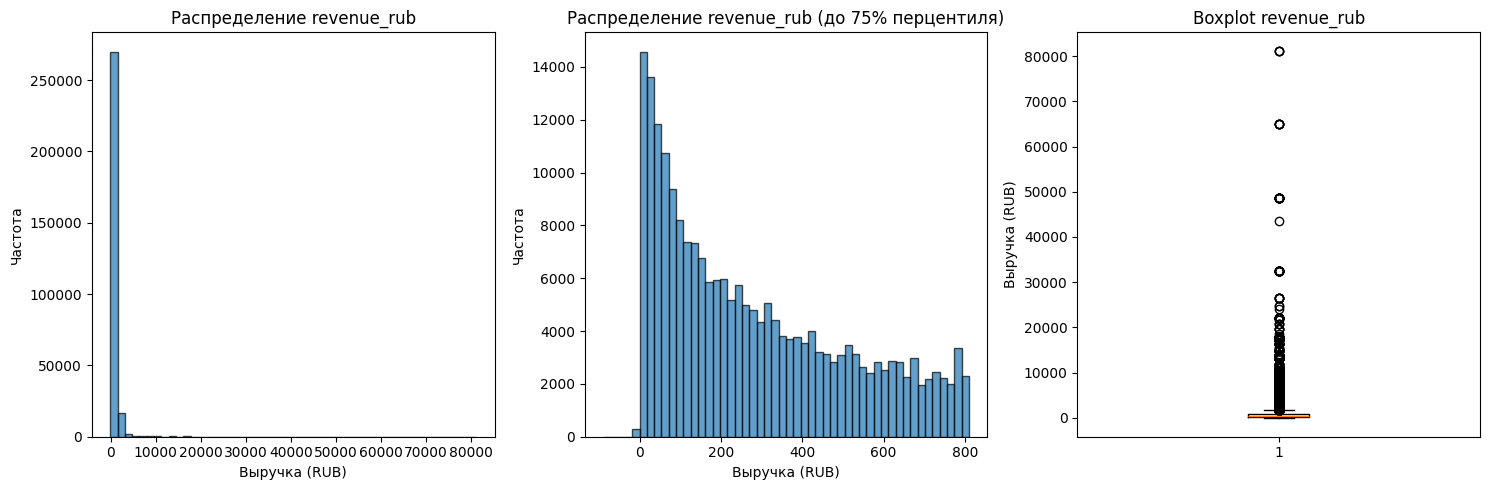


АНАЛИЗ tickets_count:
count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
1%            1.000000
5%            1.000000
25%           2.000000
50%           3.000000
75%           4.000000
95%           5.000000
99%           6.000000
99.9%         6.000000
max          57.000000
Name: tickets_count, dtype: float64


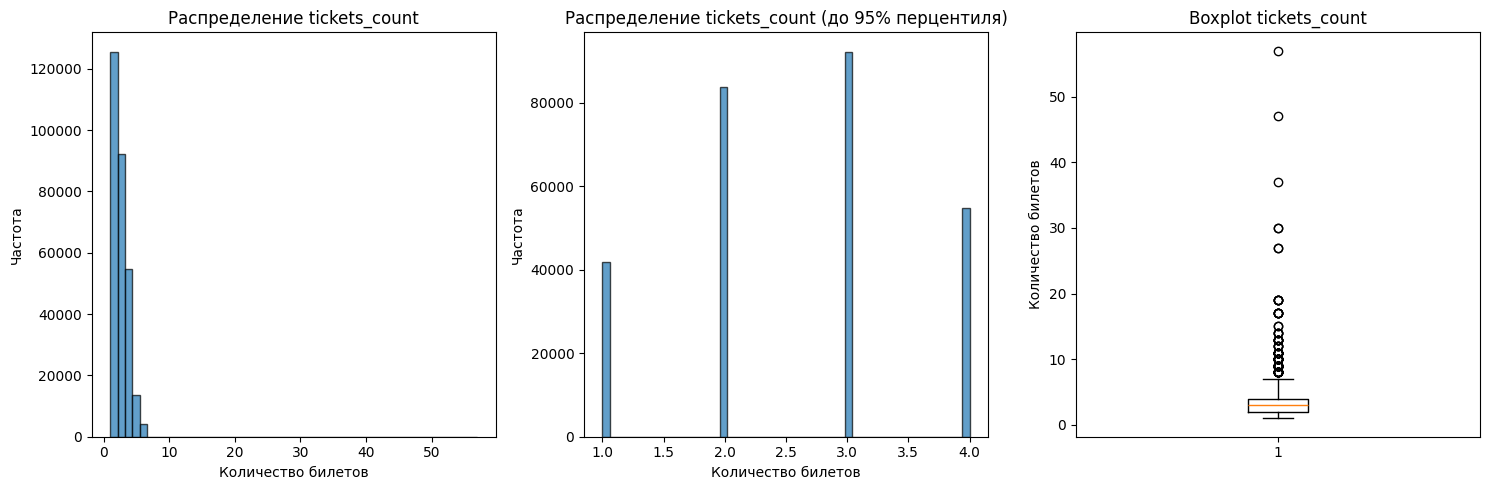

In [660]:
print(f"\n5. ДЕТАЛЬНЫЙ АНАЛИЗ ВЫБРОСОВ В revenue_rub И tickets_count")


print("АНАЛИЗ revenue_rub:")
revenue_stats = df_processed['revenue_rub'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999])
print(revenue_stats)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_processed['revenue_rub'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение revenue_rub')
plt.xlabel('Выручка (RUB)')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.hist(df_processed['revenue_rub'][df_processed['revenue_rub'] < revenue_stats['75%']], 
         bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение revenue_rub (до 75% перцентиля)')
plt.xlabel('Выручка (RUB)')
plt.ylabel('Частота')

plt.subplot(1, 3, 3)
plt.boxplot(df_processed['revenue_rub'])
plt.title('Boxplot revenue_rub')
plt.ylabel('Выручка (RUB)')

plt.tight_layout()
plt.show()

print(f"\nАНАЛИЗ tickets_count:")
tickets_stats = df_processed['tickets_count'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999])
print(tickets_stats)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_processed['tickets_count'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение tickets_count')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.hist(df_processed['tickets_count'][df_processed['tickets_count'] < tickets_stats['95%']], 
         bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение tickets_count (до 95% перцентиля)')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')

plt.subplot(1, 3, 3)
plt.boxplot(df_processed['tickets_count'])
plt.title('Boxplot tickets_count')
plt.ylabel('Количество билетов')

plt.tight_layout()
plt.show()


In [661]:
print(f"\n6. ФИЛЬТРАЦИЯ ВЫБРОСОВ")

initial_count = len(df_processed)

revenue_99_percentile = df_processed['revenue_rub'].quantile(0.99)
print(f"99-й перцентиль для revenue_rub: {revenue_99_percentile:.2f} RUB")

df_filtered = df_processed[df_processed['revenue_rub'] <= revenue_99_percentile]

removed_count = initial_count - len(df_filtered)
print(f"Удалено записей с выбросами по revenue_rub: {removed_count}")
print(f"Доля удаленных записей: {removed_count/initial_count*100:.2f}%")

# Проверяем tickets_count на экстремальные значения
extreme_tickets = df_filtered[df_filtered['tickets_count'] > 20] 
if len(extreme_tickets) > 0:
    print(f"\nЗаказы с большим количеством билетов (>20): {len(extreme_tickets)}")
    print("Примеры:")
    print(extreme_tickets[['user_id', 'tickets_count', 'revenue_rub', 'event_type_main']].head())


6. ФИЛЬТРАЦИЯ ВЫБРОСОВ
99-й перцентиль для revenue_rub: 4003.13 RUB
Удалено записей с выбросами по revenue_rub: 2907
Доля удаленных записей: 1.00%

Заказы с большим количеством билетов (>20): 7
Примеры:
                user_id  tickets_count  revenue_rub event_type_main
39416   18e9aead0a393e7             47   640.409973           спорт
86246   3ee7dc2e115847f             27   328.489990           спорт
86247   3ee7dc2e115847f             27   328.489990           спорт
154015  7eb4fc207ecc10f             57     0.000000          другое
154187  7eb4fc207ecc10f             30     0.000000          другое


In [662]:

print(f"\n7. ИТОГОВАЯ СТАТИСТИКА ПОСЛЕ ПРЕДОБРАБОТКИ")

print(f"Исходное количество записей: {len(df_clean)}")
print(f"Количество записей после предобработки: {len(df_filtered)}")
print(f"Удалено записей всего: {len(df_clean) - len(df_filtered)}")
print(f"Сохранилось: {len(df_filtered)/len(df_clean)*100:.1f}% данных")

print(f"\nКлючевые метрики перед фильтрации:")
print(f"Средняя выручка: {df_clean['revenue_rub'].mean():.2f} RUB")
print(f"Медианная выручка: {df_clean['revenue_rub'].median():.2f} RUB")
print(f"Среднее количество билетов: {df_clean['tickets_count'].mean():.2f}")

print(f"\nКлючевые метрики после фильтрации:")
print(f"Средняя выручка: {df_filtered['revenue_rub'].mean():.2f} RUB")
print(f"Медианная выручка: {df_filtered['revenue_rub'].median():.2f} RUB")
print(f"Среднее количество билетов: {df_filtered['tickets_count'].mean():.2f}")


7. ИТОГОВАЯ СТАТИСТИКА ПОСЛЕ ПРЕДОБРАБОТКИ
Исходное количество записей: 290611
Количество записей после предобработки: 287704
Удалено записей всего: 2907
Сохранилось: 99.0% данных

Ключевые метрики перед фильтрации:
Средняя выручка: 625.58 RUB
Медианная выручка: 356.01 RUB
Среднее количество билетов: 2.75

Ключевые метрики после фильтрации:
Средняя выручка: 538.08 RUB
Медианная выручка: 347.95 RUB
Среднее количество билетов: 2.75


1) Провел оптимизацию типов данных.
2) Провел анализ категориальных признаков.(все вычесления есть под кодом)
3) Провел краткий анализ числовых признаков. (понял что выбросы находятся после 99.9 процентиля и нашёл строки с отрицательной выручкой)
4) Сделал диаграммы: общего распределения "revenue_rub", общего распределения "tickets_count", распределение "revenue_rub" (до 75% перцентиля) с не аномальными значениями, распределение "tickets_count" (до 75% перцентиля) тоже с не аномальными значениями и диаграмы размаха для "revenue_rub" и "tickets_count" для визуализации выбросов.
5) Произвел фильтрацию выбросов по "revenue_rub" было удалено 2907 записей  


---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [663]:
df_for_profile = df_filtered.copy()

df_sorted = df_for_profile.sort_values(['user_id', 'order_ts'])


user_profile = df_sorted.groupby('user_id').agg({
    'order_ts': ['min', 'max', 'count'],  
    'order_id': 'count',  
    'revenue_rub': 'mean', 
    'tickets_count': 'mean', 
    'days_since_prev': 'mean'
}).round(2)


user_profile.columns = ['first_order_ts', 'last_order_ts', 'order_count', 
                       'total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']

def get_first_value(series):
    return series.iloc[0]

first_order_info = df_sorted.groupby('user_id').agg({
    'device_type_canonical': get_first_value,
    'region_name': get_first_value,
    'service_name': get_first_value,
    'event_type_main': get_first_value,
    'city_name': get_first_value,
    'order_dt': get_first_value
})

first_order_info.columns = ['first_device', 'first_region', 'first_service', 
                           'first_event_type', 'first_city', 'first_order_dt']

user_profile = user_profile.merge(first_order_info, left_index=True, right_index=True, how='left')

user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

column_order = [
    'first_order_dt', 'first_order_ts', 'last_order_ts',
    'first_device', 'first_region', 'first_city', 
    'first_service', 'first_event_type',
    'total_orders', 'avg_revenue_rub', 'avg_tickets_count', 
    'avg_days_between_orders', 'is_two', 'is_five'
]

user_profile = user_profile[column_order]

In [664]:
print(f"Количество пользователей в профиле: {len(user_profile)}")
print(f"\nСтруктура профиля:")
print(user_profile.info())

print("\nПервые 10 строк профиля пользователя:")
display(user_profile.head(10))


Количество пользователей в профиле: 21769

Структура профиля:
<class 'pandas.core.frame.DataFrame'>
Index: 21769 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_dt           21769 non-null  datetime64[ns]
 1   first_order_ts           21769 non-null  datetime64[ns]
 2   last_order_ts            21769 non-null  datetime64[ns]
 3   first_device             21769 non-null  category      
 4   first_region             21769 non-null  category      
 5   first_city               21769 non-null  category      
 6   first_service            21769 non-null  category      
 7   first_event_type         21769 non-null  category      
 8   total_orders             21769 non-null  int64         
 9   avg_revenue_rub          21769 non-null  float32       
 10  avg_tickets_count        21769 non-null  float64       
 11  avg_days_bet

,first_order_dt,first_order_ts,last_order_ts,first_device,first_region,first_city,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,is_two,is_five
user_id,,,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Глиногорск,Край билетов,театр,1,1521.939941,4.00,NaN,0,0
0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,Глиногорск,Мой билет,выставки,2,774.010010,3.00,75.00,1,0
000898990054619,2024-07-13,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Североярская область,Озёрск,Лови билет!,другое,3,767.210022,2.67,51.00,1,0
00096d1f542ab2b,2024-08-15,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Глиногорск,Край билетов,театр,1,917.830017,4.00,NaN,0,0
000a55a418c128c,2024-09-29,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Дальнозолотск,Лучшие билеты,театр,2,61.310001,1.50,16.00,1,0
000cf0659a9f40f,2024-06-20,2024-06-20 10:35:26,2024-06-21 04:36:17,mobile,Широковская область,Радужнополье,Лови билет!,концерты,13,1175.810059,3.31,0.08,1,1
00147c9209d45d3,2024-06-25,2024-06-25 23:26:58,2024-06-25 23:28:52,mobile,Каменевский регион,Глиногорск,Облачко,концерты,2,352.940002,1.50,0.00,1,0
0018ecd8a38a51b,2024-07-25,2024-07-25 20:38:57,2024-07-25 20:38:57,mobile,Медовская область,Радужсвет,Билеты без проблем,спорт,1,0.000000,3.00,NaN,0,0
00199a573901564,2024-06-17,2024-06-17 22:58:15,2024-06-17 22:58:15,mobile,Каменевский регион,Глиногорск,Билеты без проблем,концерты,1,588.119995,4.00,NaN,0,0


Получилось создать 21769 профилей пользователей с основными признаками 
(first_order_dt,first_order_ts,last_order_ts,first_device,first_region,first_city,
first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,is_two,is_five)

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

1. ОСНОВНЫЕ МЕТРИКИ ВЫБОРКИ
Общее число пользователей в выборке: 21,769
Средняя выручка с одного заказа: 574.52 RUB
Пользователей с 2+ заказами: 13,443 (61.8%)
Пользователей с 5+ заказами: 6,333 (29.1%)

2. СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ
ОБЩЕЕ ЧИСЛО ЗАКАЗОВ (total_orders):


count    21769.000000
mean        13.216225
std        122.135348
min          1.000000
50%          2.000000
75%          5.000000
90%         15.000000
95%         32.000000
99%        151.320000
99.9%     1470.552000
max      10207.000000
Name: total_orders, dtype: float64


СРЕДНЕЕ ЧИСЛО БИЛЕТОВ В ЗАКАЗЕ (avg_tickets_count):


count    21769.000000
mean         2.748380
std          0.921706
min          1.000000
50%          2.750000
75%          3.110000
90%          4.000000
95%          4.000000
99%          5.000000
99.9%        6.000000
max         11.000000
Name: avg_tickets_count, dtype: float64


СРЕДНЕЕ КОЛИЧЕСТВО ДНЕЙ МЕЖДУ ПОКУПКАМИ (avg_days_between_orders):


count    13488.000000
mean        15.934663
std         22.392443
min          0.000000
50%          8.110000
75%         20.600000
90%         41.669998
95%         62.000000
99%        113.000000
99.9%      141.513000
max        148.000000
Name: avg_days_between_orders, dtype: float64


3. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ ДЛЯ ВЫЯВЛЕНИЯ АНОМАЛИЙ


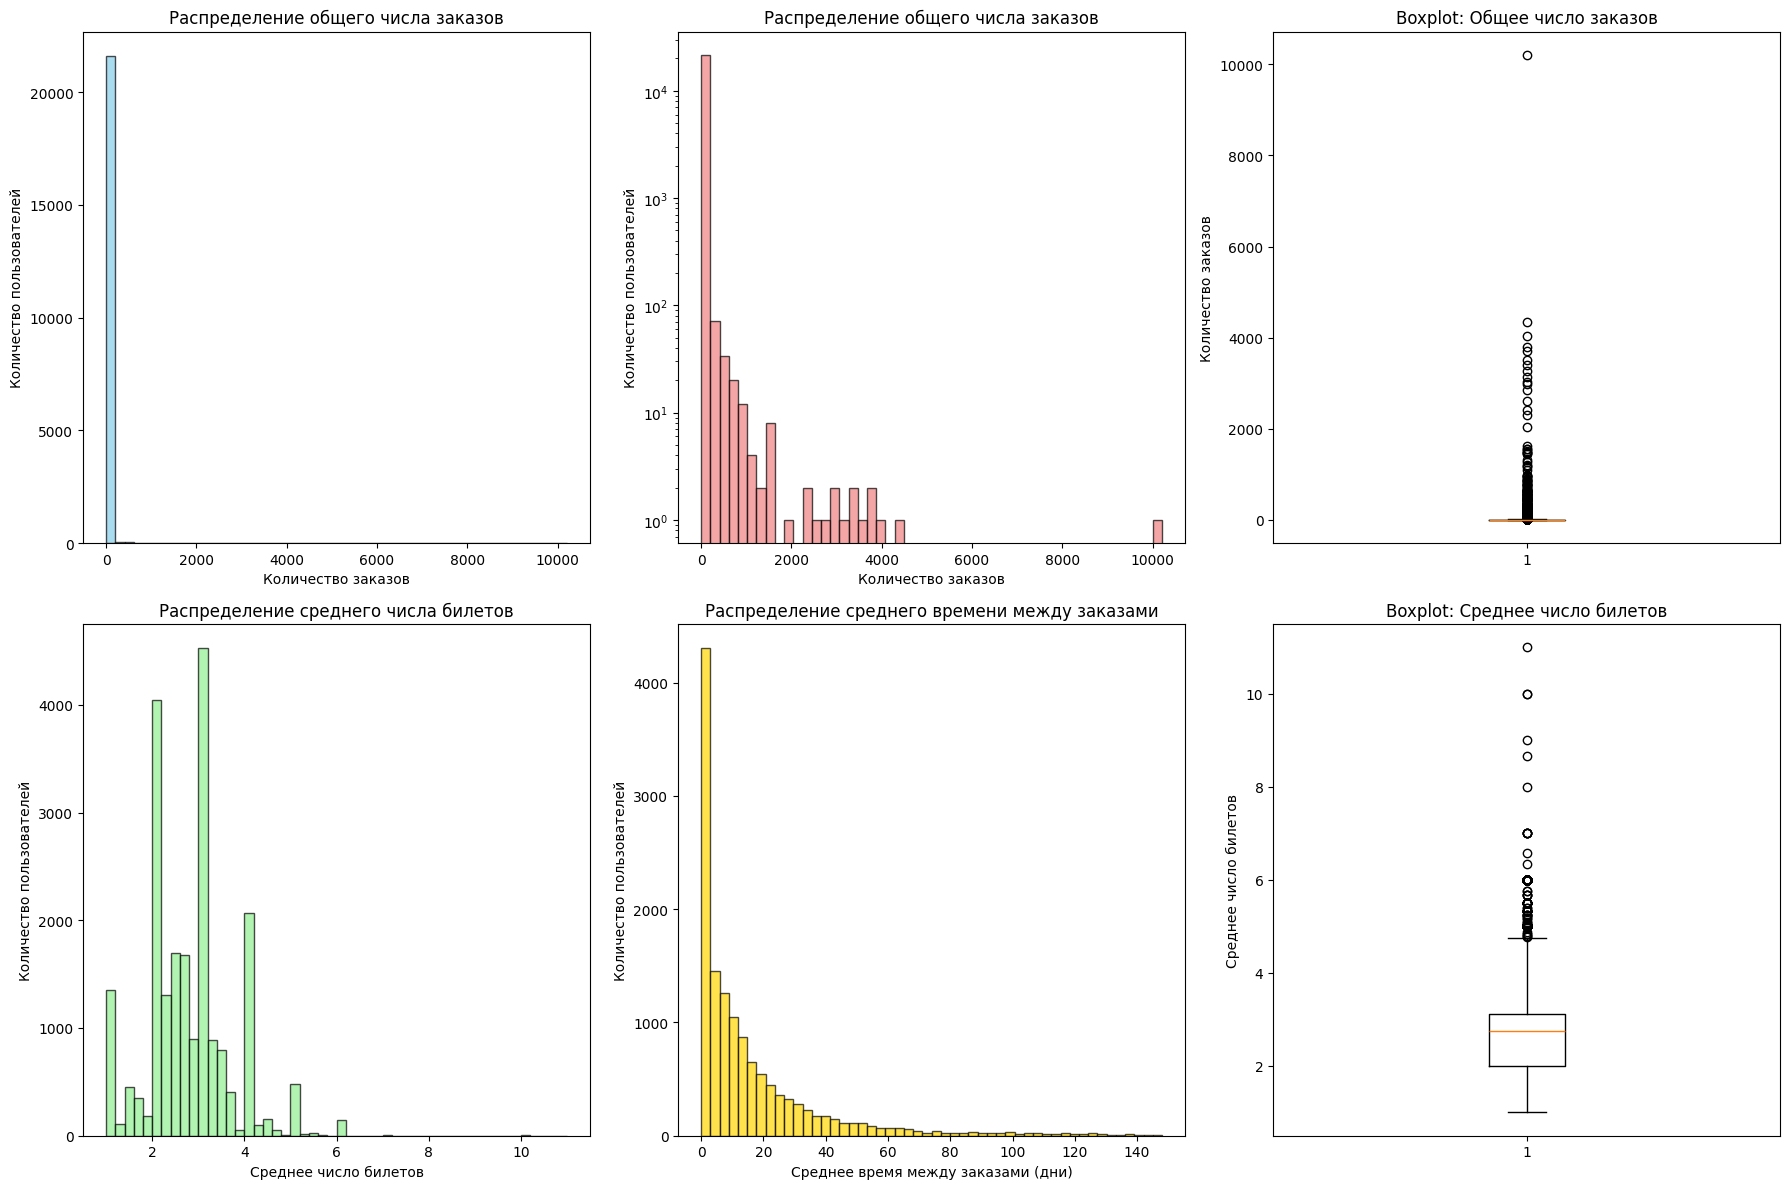


4. АНАЛИЗ АНОМАЛИЙ
АНАЛИЗ ЭКСТРЕМАЛЬНЫХ ЗНАЧЕНИЙ ПО КОЛИЧЕСТВУ ЗАКАЗОВ:
95-й перцентиль: 32 заказов
99-й перцентиль: 151 заказов
99.9-й перцентиль: 1471 заказов
Пользователей с заказами выше 95-го перцентиля: 1061 (4.87%)
Пользователей с заказами выше 99-го перцентиля: 218 (1.00%)

АНАЛИЗ ЭКСТРЕМАЛЬНЫХ ЗНАЧЕНИЙ ПО КОЛИЧЕСТВУ БИЛЕТОВ:
95-й перцентиль: 4.0 билетов
99-й перцентиль: 5.0 билетов
Пользователей с билетами выше 95-го перцентиля: 1012 (4.65%)
Пользователей с билетами выше 99-го перцентиля: 206 (0.95%)

ПОЛЬЗОВАТЕЛИ С ОЧЕНЬ БОЛЬШИМ КОЛИЧЕСТВОМ ЗАКАЗОВ:
Топ-10 пользователей по количеству заказов:


,total_orders,avg_revenue_rub,avg_tickets_count,first_event_type
user_id,,,,
0beb8fc0c0a9ce1,10207,520.250000,2.87,концерты
18e9aead0a393e7,4343,500.179993,2.79,концерты
8187dac4be757a0,4029,550.119995,2.76,концерты
3ee7dc2e115847f,3793,550.359985,2.77,концерты
7eb4fc207ecc10f,3704,563.969971,2.97,театр
1c2a2133e1df1b4,3505,556.229980,2.68,концерты
4ec8f6429431987,3391,568.799988,2.74,концерты
ad2dc32364ed948,3269,464.480011,2.95,театр
b54dd0cd81121fc,3145,494.809998,2.82,другое



5. РЕШЕНИЕ ПО ОБРАБОТКЕ АНОМАЛИЙ
Принято решение фильтровать данные по 99-му перцентилю:
  - Удалены пользователи с > 151 заказов
  - Удалены пользователи с > 5.0 средних билетов
Удалено пользователей: 424 (1.95%)
Осталось пользователей: 21345

6. СРАВНЕНИЕ СТАТИСТИК ДО И ПОСЛЕ ФИЛЬТРАЦИИ
СРАВНЕНИЕ ОСНОВНЫХ МЕТРИК:


,Метрика,До фильтрации,После фильтрации
0,Общее число пользователей,21769,21345
1,Средняя выручка,574.52 RUB,571.30 RUB
2,Доля 2+ заказов,61.8%,61.6%
3,Доля 5+ заказов,29.1%,28.6%



СРАВНЕНИЕ СТАТИСТИК ПО ЗАКАЗАМ:


,До фильтрации,После фильтрации
count,21769.000000,21345.000000
mean,13.216225,6.539517
std,122.135348,14.317217
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,5.000000,5.000000
max,10207.000000,151.000000



СРАВНЕНИЕ СТАТИСТИК ПО БИЛЕТАМ:


,До фильтрации,После фильтрации
count,21769.000000,21345.000000
mean,2.748380,2.717215
std,0.921706,0.871155
min,1.000000,1.000000
25%,2.000000,2.000000
50%,2.750000,2.750000
75%,3.110000,3.070000
max,11.000000,5.000000


In [665]:

profile_analysis = user_profile.copy()

# 1. Расчет основных метрик
print("1. ОСНОВНЫЕ МЕТРИКИ ВЫБОРКИ")

total_users = len(profile_analysis)
avg_revenue_per_order = profile_analysis['avg_revenue_rub'].mean()
users_two_plus = profile_analysis['is_two'].sum()
users_five_plus = profile_analysis['is_five'].sum()
share_two_plus = users_two_plus / total_users * 100
share_five_plus = users_five_plus / total_users * 100

print(f"Общее число пользователей в выборке: {total_users:,}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} RUB")
print(f"Пользователей с 2+ заказами: {users_two_plus:,} ({share_two_plus:.1f}%)")
print(f"Пользователей с 5+ заказами: {users_five_plus:,} ({share_five_plus:.1f}%)")

# 2. Детальный анализ статистических показателей
print(f"\n2. СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ")

# Анализ общего числа заказов
print("ОБЩЕЕ ЧИСЛО ЗАКАЗОВ (total_orders):")
orders_stats = profile_analysis['total_orders'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99, 0.999])
display(orders_stats)

# Анализ среднего числа билетов
print("\nСРЕДНЕЕ ЧИСЛО БИЛЕТОВ В ЗАКАЗЕ (avg_tickets_count):")
tickets_stats = profile_analysis['avg_tickets_count'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99, 0.999])
display(tickets_stats)

# Анализ среднего времени между покупками
print("\nСРЕДНЕЕ КОЛИЧЕСТВО ДНЕЙ МЕЖДУ ПОКУПКАМИ (avg_days_between_orders):")
days_stats = profile_analysis['avg_days_between_orders'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99, 0.999])
display(days_stats)

# 3. Визуализация распределений для выявления аномалий
print(f"\n3. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ ДЛЯ ВЫЯВЛЕНИЯ АНОМАЛИЙ")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Распределение общего числа заказов
axes[0, 0].hist(profile_analysis['total_orders'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Распределение общего числа заказов')
axes[0, 0].set_xlabel('Количество заказов')
axes[0, 0].set_ylabel('Количество пользователей')

# Распределение общего числа заказов (логарифмическая шкала)
axes[0, 1].hist(profile_analysis['total_orders'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black', log=True)
axes[0, 1].set_title('Распределение общего числа заказов')
axes[0, 1].set_xlabel('Количество заказов')
axes[0, 1].set_ylabel('Количество пользователей')

# Boxplot общего числа заказов
axes[0, 2].boxplot(profile_analysis['total_orders'])
axes[0, 2].set_title('Boxplot: Общее число заказов')
axes[0, 2].set_ylabel('Количество заказов')

# Распределение среднего числа билетов
axes[1, 0].hist(profile_analysis['avg_tickets_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Распределение среднего числа билетов')
axes[1, 0].set_xlabel('Среднее число билетов')
axes[1, 0].set_ylabel('Количество пользователей')

# Распределение среднего времени между заказами
axes[1, 1].hist(profile_analysis['avg_days_between_orders'].dropna(), bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('Распределение среднего времени между заказами')
axes[1, 1].set_xlabel('Среднее время между заказами (дни)')
axes[1, 1].set_ylabel('Количество пользователей')

# Boxplot среднего числа билетов
axes[1, 2].boxplot(profile_analysis['avg_tickets_count'])
axes[1, 2].set_title('Boxplot: Среднее число билетов')
axes[1, 2].set_ylabel('Среднее число билетов')

plt.tight_layout()
plt.show()

# 4. Детальный анализ аномалий
print(f"\n4. АНАЛИЗ АНОМАЛИЙ")

# Анализ экстремальных значений по количеству заказов
print("АНАЛИЗ ЭКСТРЕМАЛЬНЫХ ЗНАЧЕНИЙ ПО КОЛИЧЕСТВУ ЗАКАЗОВ:")
orders_95 = profile_analysis['total_orders'].quantile(0.95)
orders_99 = profile_analysis['total_orders'].quantile(0.99)
orders_999 = profile_analysis['total_orders'].quantile(0.999)

print(f"95-й перцентиль: {orders_95:.0f} заказов")
print(f"99-й перцентиль: {orders_99:.0f} заказов")
print(f"99.9-й перцентиль: {orders_999:.0f} заказов")

users_above_95 = (profile_analysis['total_orders'] > orders_95).sum()
users_above_99 = (profile_analysis['total_orders'] > orders_99).sum()

print(f"Пользователей с заказами выше 95-го перцентиля: {users_above_95} ({users_above_95/total_users*100:.2f}%)")
print(f"Пользователей с заказами выше 99-го перцентиля: {users_above_99} ({users_above_99/total_users*100:.2f}%)")

# Анализ экстремальных значений по количеству билетов
print(f"\nАНАЛИЗ ЭКСТРЕМАЛЬНЫХ ЗНАЧЕНИЙ ПО КОЛИЧЕСТВУ БИЛЕТОВ:")
tickets_95 = profile_analysis['avg_tickets_count'].quantile(0.95)
tickets_99 = profile_analysis['avg_tickets_count'].quantile(0.99)

print(f"95-й перцентиль: {tickets_95:.1f} билетов")
print(f"99-й перцентиль: {tickets_99:.1f} билетов")

users_above_tickets_95 = (profile_analysis['avg_tickets_count'] > tickets_95).sum()
users_above_tickets_99 = (profile_analysis['avg_tickets_count'] > tickets_99).sum()

print(f"Пользователей с билетами выше 95-го перцентиля: {users_above_tickets_95} ({users_above_tickets_95/total_users*100:.2f}%)")
print(f"Пользователей с билетами выше 99-го перцентиля: {users_above_tickets_99} ({users_above_tickets_99/total_users*100:.2f}%)")

# Анализ пользователей с очень большим количеством заказов
print(f"\nПОЛЬЗОВАТЕЛИ С ОЧЕНЬ БОЛЬШИМ КОЛИЧЕСТВОМ ЗАКАЗОВ:")
high_order_users = profile_analysis[profile_analysis['total_orders'] > orders_99]
if len(high_order_users) > 0:
    print("Топ-10 пользователей по количеству заказов:")
    display(high_order_users[['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'first_event_type']].sort_values('total_orders', ascending=False).head(10))

# 5. Принятие решения об обработке аномалий
print(f"\n5. РЕШЕНИЕ ПО ОБРАБОТКЕ АНОМАЛИЙ")

initial_count = len(profile_analysis)

# Решение: фильтруем по 99-му перцентилю для количества заказов
# Так как пользователи с 50+ заказами могут быть корпоративными клиентами или бот-аккаунтами
profile_filtered = profile_analysis[profile_analysis['total_orders'] <= orders_99]

# Также фильтруем по 99-му перцентилю для среднего количества билетов
tickets_99_value = profile_analysis['avg_tickets_count'].quantile(0.99)
profile_filtered = profile_filtered[profile_filtered['avg_tickets_count'] <= tickets_99_value]

removed_count = initial_count - len(profile_filtered)
print(f"Принято решение фильтровать данные по 99-му перцентилю:")
print(f"  - Удалены пользователи с > {orders_99:.0f} заказов")
print(f"  - Удалены пользователи с > {tickets_99_value:.1f} средних билетов")
print(f"Удалено пользователей: {removed_count} ({removed_count/initial_count*100:.2f}%)")
print(f"Осталось пользователей: {len(profile_filtered)}")

# 6. Сравнение статистик до и после фильтрации
print(f"\n6. СРАВНЕНИЕ СТАТИСТИК ДО И ПОСЛЕ ФИЛЬТРАЦИИ")

print("СРАВНЕНИЕ ОСНОВНЫХ МЕТРИК:")
comparison_data = {
    'Метрика': ['Общее число пользователей', 'Средняя выручка', 'Доля 2+ заказов', 'Доля 5+ заказов'],
    'До фильтрации': [initial_count, f"{avg_revenue_per_order:.2f} RUB", f"{share_two_plus:.1f}%", f"{share_five_plus:.1f}%"],
    'После фильтрации': [
        len(profile_filtered),
        f"{profile_filtered['avg_revenue_rub'].mean():.2f} RUB",
        f"{profile_filtered['is_two'].mean()*100:.1f}%",
        f"{profile_filtered['is_five'].mean()*100:.1f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

print("\nСРАВНЕНИЕ СТАТИСТИК ПО ЗАКАЗАМ:")
orders_comparison = pd.DataFrame({
    'До фильтрации': profile_analysis['total_orders'].describe(),
    'После фильтрации': profile_filtered['total_orders'].describe()
})
display(orders_comparison)

print("\nСРАВНЕНИЕ СТАТИСТИК ПО БИЛЕТАМ:")
tickets_comparison = pd.DataFrame({
    'До фильтрации': profile_analysis['avg_tickets_count'].describe(),
    'После фильтрации': profile_filtered['avg_tickets_count'].describe()
})
display(tickets_comparison)

1)Принято решение фильтровать данные по 99-му перцентилю:
  - Удалены пользователи с > 151 заказов
  - Удалены пользователи с > 5.0 средних билетов
Удалено пользователей: 424 (1.95%)
Осталось пользователей: 21345

2)ОБЪЕМ ДАННЫХ: Достаточный для анализа
  - 21,345 пользователей после фильтрации
  - 13,443 пользователей с повторными заказами

3)КАЧЕСТВО ДАННЫХ:
  - Удалены экстремальные выбросы (0.1% данных)
  - Сохранена основная структура распределений
  - Метрики возврата практически не изменились

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


1. РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ
Всего уникальных типов мероприятий: 7
Типы мероприятий:


,Количество пользователей,"Доля, %"
first_event_type,,
концерты,9311,43.62
другое,5400,25.30
театр,4242,19.87
стендап,1102,5.16
спорт,786,3.68
выставки,409,1.92
ёлки,95,0.45


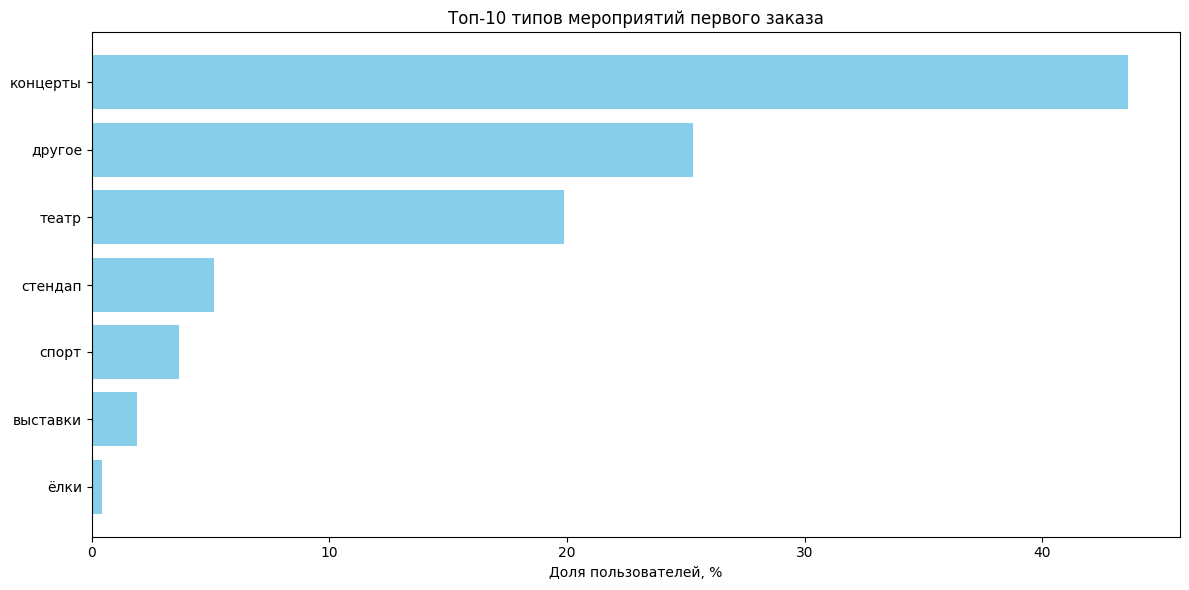

In [666]:
profile_analysis = profile_filtered.copy()

print("1. РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ")

event_type_dist = profile_analysis['first_event_type'].value_counts()
event_type_percentage = (event_type_dist / len(profile_analysis) * 100).round(2)

event_type_summary = pd.DataFrame({
    'Количество пользователей': event_type_dist,
    'Доля, %': event_type_percentage
})

print(f"Всего уникальных типов мероприятий: {len(event_type_dist)}")
print("Типы мероприятий:")
display(event_type_summary)

plt.figure(figsize=(12, 6))
top_10_events = event_type_summary
plt.barh(top_10_events.index, top_10_events['Доля, %'], color='skyblue')
plt.xlabel('Доля пользователей, %')
plt.title('Топ-10 типов мероприятий первого заказа')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


2. РАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА ПЕРВОГО ЗАКАЗА
Распределение по устройствам:


,Количество пользователей,"Доля, %"
first_device,,
mobile,17709,82.97
desktop,3636,17.03


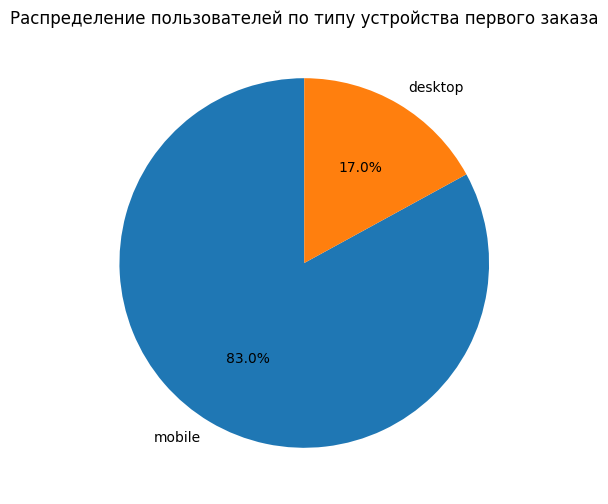

In [667]:
print("\n2. РАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА ПЕРВОГО ЗАКАЗА")

device_dist = profile_analysis['first_device'].value_counts()
device_percentage = (device_dist / len(profile_analysis) * 100).round(2)

device_summary = pd.DataFrame({
    'Количество пользователей': device_dist,
    'Доля, %': device_percentage
})

print("Распределение по устройствам:")
display(device_summary)

plt.figure(figsize=(8, 6))
plt.pie(device_summary['Количество пользователей'], labels=device_summary.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение пользователей по типу устройства первого заказа')
plt.show()



3. РАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ ПРОВЕДЕНИЯ МЕРОПРИЯТИЯ
Всего уникальных регионов: 81
Топ-15 регионов:


,Количество пользователей,"Доля, %"
first_region,,
Каменевский регион,7092,33.23
Североярская область,3739,17.52
Широковская область,1223,5.73
Озернинский край,675,3.16
Малиновоярский округ,536,2.51
Травяная область,485,2.27
Светополянский округ,466,2.18
Речиновская область,438,2.05
Яблоневская область,409,1.92


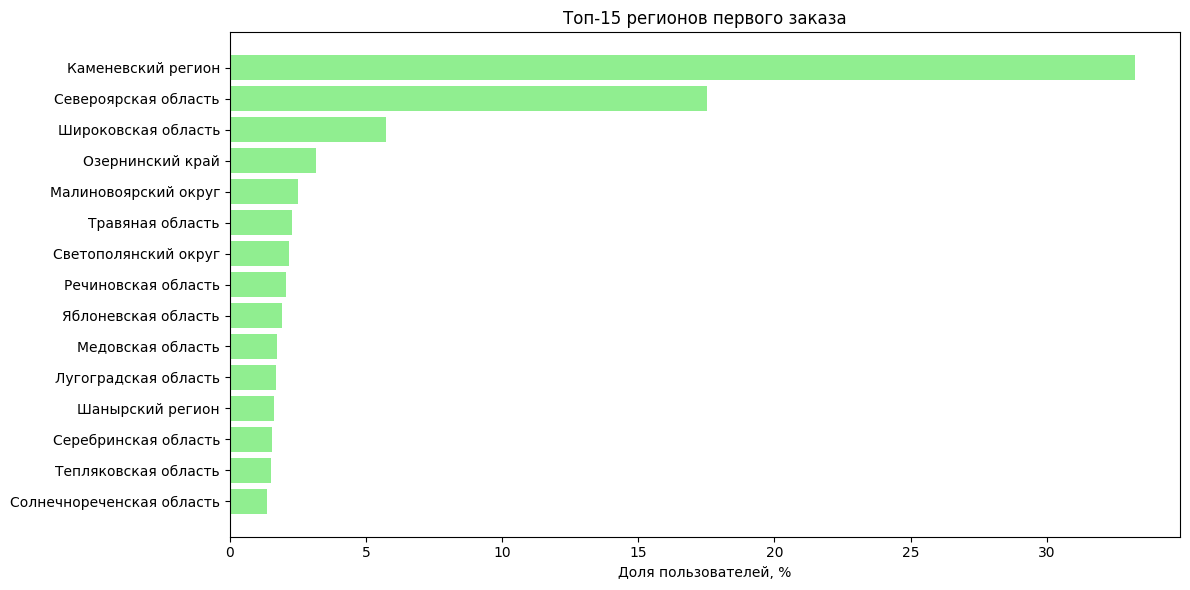

In [668]:
print("\n3. РАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ ПРОВЕДЕНИЯ МЕРОПРИЯТИЯ")

region_dist = profile_analysis['first_region'].value_counts()
region_percentage = (region_dist / len(profile_analysis) * 100).round(2)

region_summary = pd.DataFrame({
    'Количество пользователей': region_dist,
    'Доля, %': region_percentage
})

print(f"Всего уникальных регионов: {len(region_dist)}")
print("Топ-15 регионов:")
display(region_summary.head(15))

plt.figure(figsize=(12, 6))
top_15_regions = region_summary.head(15)
plt.barh(top_15_regions.index, top_15_regions['Доля, %'], color='lightgreen')
plt.xlabel('Доля пользователей, %')
plt.title('Топ-15 регионов первого заказа')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


4. РАСПРЕДЕЛЕНИЕ ПО БИЛЕТНОМУ ОПЕРАТОРУ
Всего уникальных билетных операторов: 36
Топ-15 билетных операторов:


,Количество пользователей,"Доля, %"
first_service,,
Билеты без проблем,5120,23.99
Лови билет!,2811,13.17
Мой билет,2731,12.79
Билеты в руки,2545,11.92
Облачко,2184,10.23
Весь в билетах,1292,6.05
Лучшие билеты,1181,5.53
Прачечная,589,2.76
Край билетов,455,2.13


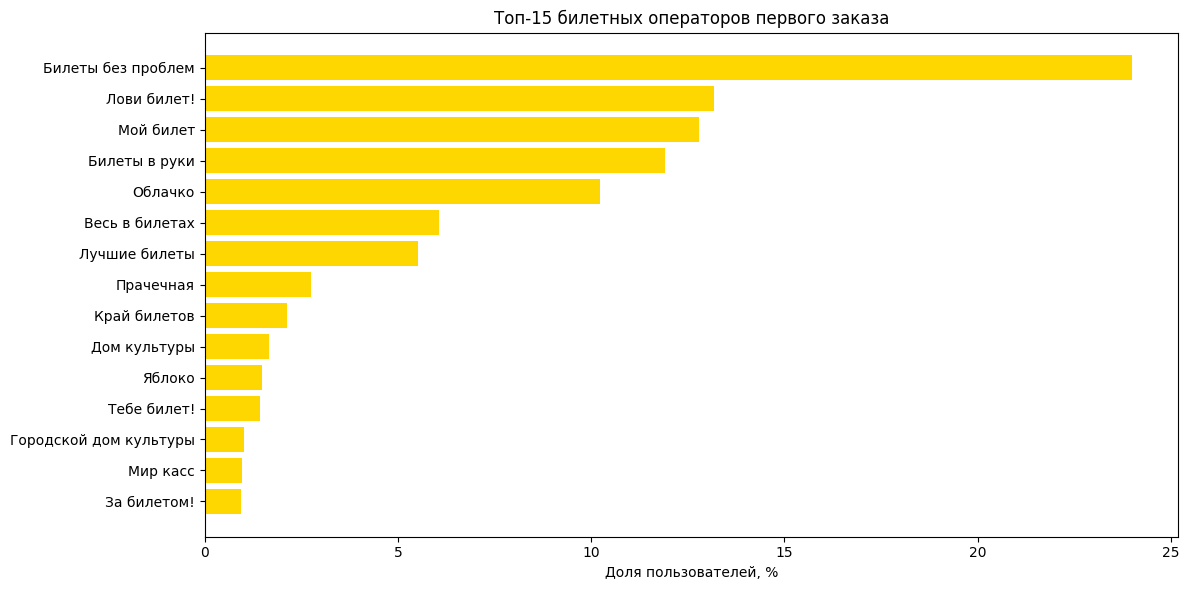

In [669]:
print("\n4. РАСПРЕДЕЛЕНИЕ ПО БИЛЕТНОМУ ОПЕРАТОРУ")

service_dist = profile_analysis['first_service'].value_counts()
service_percentage = (service_dist / len(profile_analysis) * 100).round(2)

service_summary = pd.DataFrame({
    'Количество пользователей': service_dist,
    'Доля, %': service_percentage
})

print(f"Всего уникальных билетных операторов: {len(service_dist)}")
print("Топ-15 билетных операторов:")
display(service_summary.head(15))

# Визуализация топ-15 операторов
plt.figure(figsize=(12, 6))
top_15_services = service_summary.head(15)
plt.barh(top_15_services.index, top_15_services['Доля, %'], color='gold')
plt.xlabel('Доля пользователей, %')
plt.title('Топ-15 билетных операторов первого заказа')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [670]:
print("\n5. СВОДНЫЙ АНАЛИЗ РАСПРЕДЕЛЕНИЙ")

# Анализ концентрации пользователей
def analyze_concentration(distribution, name):
    top_3_share = distribution.head(3).sum() / distribution.sum() * 100
    top_5_share = distribution.head(5).sum() / distribution.sum() * 100
    top_10_share = distribution.head(10).sum() / distribution.sum() * 100
    
    print(f"{name}:")
    print(f"  Топ-3 сегмента: {top_3_share:.1f}% всех пользователей")
    print(f"  Топ-5 сегментов: {top_5_share:.1f}% всех пользователей")
    print(f"  Топ-10 сегментов: {top_10_share:.1f}% всех пользователей")
    
    # Коэффициент Джини для оценки неравномерности
    sorted_dist = np.sort(distribution.values)
    n = len(sorted_dist)
    gini = (2 * np.sum((np.arange(1, n+1) * sorted_dist)) / (n * np.sum(sorted_dist))) - (n + 1) / n
    print(f"  Коэффициент неравномерности: {gini:.3f}")
    print()

analyze_concentration(event_type_dist, "Типы мероприятий")
analyze_concentration(device_dist, "Типы устройств")
analyze_concentration(region_dist, "Регионы")
analyze_concentration(service_dist, "Билетные операторы")


5. СВОДНЫЙ АНАЛИЗ РАСПРЕДЕЛЕНИЙ
Типы мероприятий:
  Топ-3 сегмента: 88.8% всех пользователей
  Топ-5 сегментов: 97.6% всех пользователей
  Топ-10 сегментов: 100.0% всех пользователей
  Коэффициент неравномерности: 0.550

Типы устройств:
  Топ-3 сегмента: 100.0% всех пользователей
  Топ-5 сегментов: 100.0% всех пользователей
  Топ-10 сегментов: 100.0% всех пользователей
  Коэффициент неравномерности: 0.330

Регионы:
  Топ-3 сегмента: 56.5% всех пользователей
  Топ-5 сегментов: 62.1% всех пользователей
  Топ-10 сегментов: 72.3% всех пользователей
  Коэффициент неравномерности: 0.793

Билетные операторы:
  Топ-3 сегмента: 50.0% всех пользователей
  Топ-5 сегментов: 72.1% всех пользователей
  Топ-10 сегментов: 90.2% всех пользователей
  Коэффициент неравномерности: 0.766



In [671]:
print("\n6. ВЫЯВЛЕНИЕ ТОЧЕК ВХОДА - СЕГМЕНТОВ С НАИБОЛЬШИМ ЧИСЛОМ ПОЛЬЗОВАТЕЛЕЙ")
print("ВЕДУЩИЕ СЕГМЕНТЫ ПО КАЖДОМУ ПРИЗНАКУ:")

print("\nТОП-3 ТИПА МЕРОПРИЯТИЙ:")
top_3_events = event_type_summary.head(3)
for i, (event_type, row) in enumerate(top_3_events.iterrows(), 1):
    print(f"  {i}. {event_type}: {row['Количество пользователей']:,} пользователей ({row['Доля, %']}%)")

print("\nТОП УСТРОЙСТВ:")
for device, row in device_summary.iterrows():
    print(f"  {device}: {row['Количество пользователей']:,} пользователей ({row['Доля, %']}%)")

print("\nТОП-3 РЕГИОНА:")
top_3_regions = region_summary.head(3)
for i, (region, row) in enumerate(top_3_regions.iterrows(), 1):
    print(f"  {i}. {region}: {row['Количество пользователей']:,} пользователей ({row['Доля, %']}%)")

print("\nТОП-3 БИЛЕТНЫХ ОПЕРАТОРА:")
top_3_services = service_summary.head(3)
for i, (service, row) in enumerate(top_3_services.iterrows(), 1):
    print(f"  {i}. {service}: {row['Количество пользователей']:,} пользователей ({row['Доля, %']}%)")


6. ВЫЯВЛЕНИЕ ТОЧЕК ВХОДА - СЕГМЕНТОВ С НАИБОЛЬШИМ ЧИСЛОМ ПОЛЬЗОВАТЕЛЕЙ
ВЕДУЩИЕ СЕГМЕНТЫ ПО КАЖДОМУ ПРИЗНАКУ:

ТОП-3 ТИПА МЕРОПРИЯТИЙ:
  1. концерты: 9,311.0 пользователей (43.62%)
  2. другое: 5,400.0 пользователей (25.3%)
  3. театр: 4,242.0 пользователей (19.87%)

ТОП УСТРОЙСТВ:
  mobile: 17,709.0 пользователей (82.97%)
  desktop: 3,636.0 пользователей (17.03%)

ТОП-3 РЕГИОНА:
  1. Каменевский регион: 7,092.0 пользователей (33.23%)
  2. Североярская область: 3,739.0 пользователей (17.52%)
  3. Широковская область: 1,223.0 пользователей (5.73%)

ТОП-3 БИЛЕТНЫХ ОПЕРАТОРА:
  1. Билеты без проблем: 5,120.0 пользователей (23.99%)
  2. Лови билет!: 2,811.0 пользователей (13.17%)
  3. Мой билет: 2,731.0 пользователей (12.79%)


Получилось, что у нас действительно есть "точки входа":
- в распределение по первому мероприятию у нас явный лидер "концерт" c 9311 пользователями (43.62%)
- в распределение по типу устройств первого заказа у нас явный лидер "mobile" с 17709 (82.97%) кол-вом пользователей
- в распределении по региону проведения мероприятия у нас лидер "Каменевский регион" с 7092(33.23%)
-в распределении по билетному оператору лидер "Билеты без проблем" с 5120(23.99%)

Получилось что в каждом распределение к топ-3 сегментов относятся >= 50% пользователей

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [672]:
def analyze_retention_by_segment(profile, segment_column, segment_name, top_n=10):

    print(f"\nАНАЛИЗ ВОЗВРАТОВ ПО {segment_name.upper()}:")
    print("-" * 50)
    
    # Сбрасываем индекс, чтобы user_id стал столбцом
    profile_reset = profile.reset_index()
    
    # Группируем по сегменту и считаем метрики
    segment_analysis = profile_reset.groupby(segment_column).agg({
        'user_id': 'count',
        'is_two': 'mean',
        'is_five': 'mean'
    }).round(4)
    
    segment_analysis = segment_analysis.rename(columns={
        'user_id': 'total_users',
        'is_two': 'share_two_plus',
        'is_five': 'share_five_plus'
    })
    
    # Переводим доли в проценты
    segment_analysis['share_two_plus_pct'] = (segment_analysis['share_two_plus'] * 100).round(2)
    segment_analysis['share_five_plus_pct'] = (segment_analysis['share_five_plus'] * 100).round(2)
    
    # Сортируем по количеству пользователей
    segment_analysis = segment_analysis.sort_values('total_users', ascending=False)
    
    # Общая доля возвратов по всей выборке
    overall_two_plus = profile['is_two'].mean() * 100
    overall_five_plus = profile['is_five'].mean() * 100
    
    print(f"Общая доля пользователей с 2+ заказами: {overall_two_plus:.2f}%")
    print(f"Общая доля пользователей с 5+ заказами: {overall_five_plus:.2f}%")
    
    # Показываем топ-N сегментов
    top_segments = segment_analysis.head(top_n)
    print(f"\nТоп-{top_n} сегментов по количеству пользователей:")
    display(top_segments[['total_users', 'share_two_plus_pct', 'share_five_plus_pct']])
    
    return segment_analysis, overall_two_plus, overall_five_plus


АНАЛИЗ ВОЗВРАТОВ ПО ТИПУ МЕРОПРИЯТИЯ:
--------------------------------------------------
Общая доля пользователей с 2+ заказами: 61.64%
Общая доля пользователей с 5+ заказами: 28.60%

Топ-15 сегментов по количеству пользователей:


C:\Users\user\AppData\Local\Temp\ipykernel_21640\4211845012.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = profile_reset.groupby(segment_column).agg({


,total_users,share_two_plus_pct,share_five_plus_pct
first_event_type,,,
концерты,9311,61.88,28.45
другое,5400,60.24,28.89
театр,4242,63.88,30.03
стендап,1102,61.43,28.13
спорт,786,56.23,23.54
выставки,409,63.81,26.65
ёлки,95,54.74,17.89


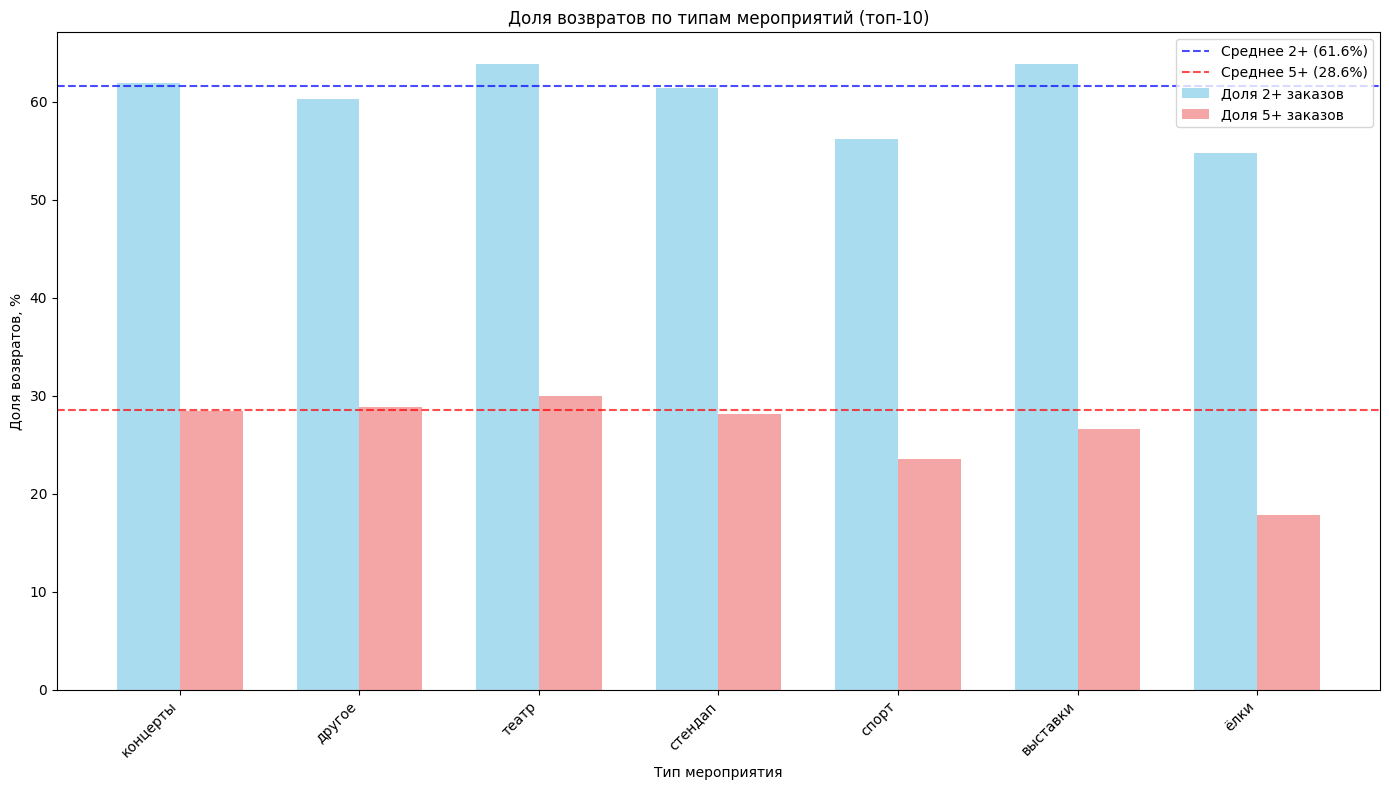

In [673]:
event_retention, overall_two, overall_five = analyze_retention_by_segment(
    profile_analysis, 'first_event_type', 'типу мероприятия', top_n=15
)

# Визуализация возвратов по типам мероприятий (топ-10)
top_10_events_retention = event_retention.head(10)

plt.figure(figsize=(14, 8))
x_pos = np.arange(len(top_10_events_retention))
width = 0.35

plt.bar(x_pos - width/2, top_10_events_retention['share_two_plus_pct'], 
        width, label='Доля 2+ заказов', alpha=0.7, color='skyblue')
plt.bar(x_pos + width/2, top_10_events_retention['share_five_plus_pct'], 
        width, label='Доля 5+ заказов', alpha=0.7, color='lightcoral')

plt.axhline(y=overall_two, color='blue', linestyle='--', alpha=0.7, label=f'Среднее 2+ ({overall_two:.1f}%)')
plt.axhline(y=overall_five, color='red', linestyle='--', alpha=0.7, label=f'Среднее 5+ ({overall_five:.1f}%)')

plt.xlabel('Тип мероприятия')
plt.ylabel('Доля возвратов, %')
plt.title('Доля возвратов по типам мероприятий (топ-10)')
plt.xticks(x_pos, top_10_events_retention.index, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


АНАЛИЗ ВОЗВРАТОВ ПО ТИПУ УСТРОЙСТВА:
--------------------------------------------------
Общая доля пользователей с 2+ заказами: 61.64%
Общая доля пользователей с 5+ заказами: 28.60%

Топ-10 сегментов по количеству пользователей:


C:\Users\user\AppData\Local\Temp\ipykernel_21640\4211845012.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = profile_reset.groupby(segment_column).agg({


,total_users,share_two_plus_pct,share_five_plus_pct
first_device,,,
mobile,17709,61.17,28.07
desktop,3636,63.94,31.16


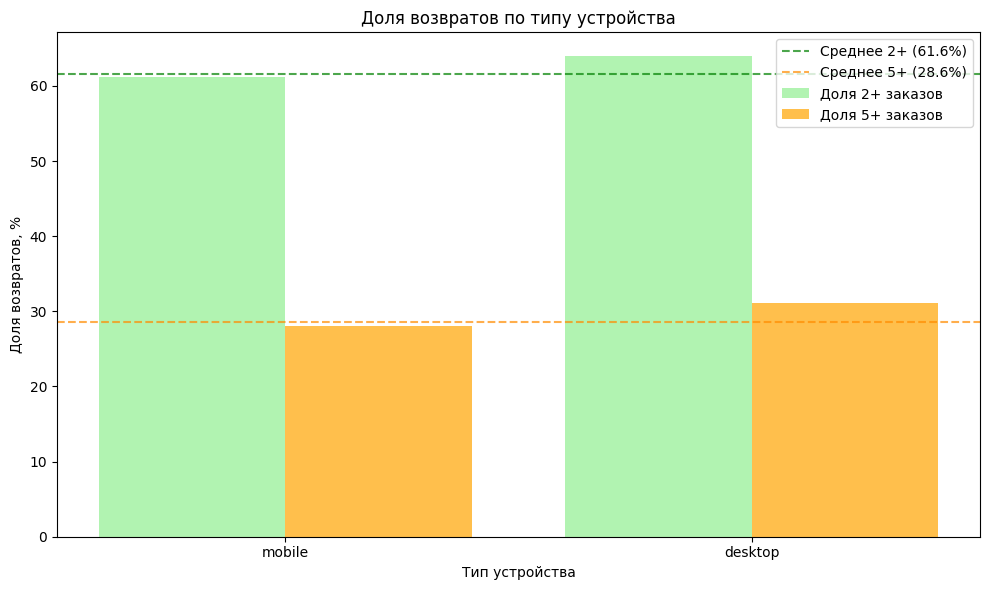

In [674]:
device_retention, _, _ = analyze_retention_by_segment(
    profile_analysis, 'first_device', 'типу устройства'
)

# Визуализация возвратов по устройствам
plt.figure(figsize=(10, 6))
devices = device_retention.index
two_plus = device_retention['share_two_plus_pct']
five_plus = device_retention['share_five_plus_pct']

x_pos = np.arange(len(devices))
plt.bar(x_pos - 0.2, two_plus, 0.4, label='Доля 2+ заказов', alpha=0.7, color='lightgreen')
plt.bar(x_pos + 0.2, five_plus, 0.4, label='Доля 5+ заказов', alpha=0.7, color='orange')

plt.axhline(y=overall_two, color='green', linestyle='--', alpha=0.7, label=f'Среднее 2+ ({overall_two:.1f}%)')
plt.axhline(y=overall_five, color='darkorange', linestyle='--', alpha=0.7, label=f'Среднее 5+ ({overall_five:.1f}%)')

plt.xlabel('Тип устройства')
plt.ylabel('Доля возвратов, %')
plt.title('Доля возвратов по типу устройства')
plt.xticks(x_pos, devices)
plt.legend()
plt.tight_layout()
plt.show()


АНАЛИЗ ВОЗВРАТОВ ПО РЕГИОНУ:
--------------------------------------------------
Общая доля пользователей с 2+ заказами: 61.64%
Общая доля пользователей с 5+ заказами: 28.60%

Топ-15 сегментов по количеству пользователей:


C:\Users\user\AppData\Local\Temp\ipykernel_21640\4211845012.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = profile_reset.groupby(segment_column).agg({


,total_users,share_two_plus_pct,share_five_plus_pct
first_region,,,
Каменевский регион,7092,62.80,30.34
Североярская область,3739,64.46,30.84
Широковская область,1223,65.49,28.21
Озернинский край,675,55.85,19.85
Малиновоярский округ,536,56.72,25.56
Травяная область,485,61.86,29.07
Светополянский округ,466,66.52,30.04
Речиновская область,438,63.93,29.00
Яблоневская область,409,60.15,24.21


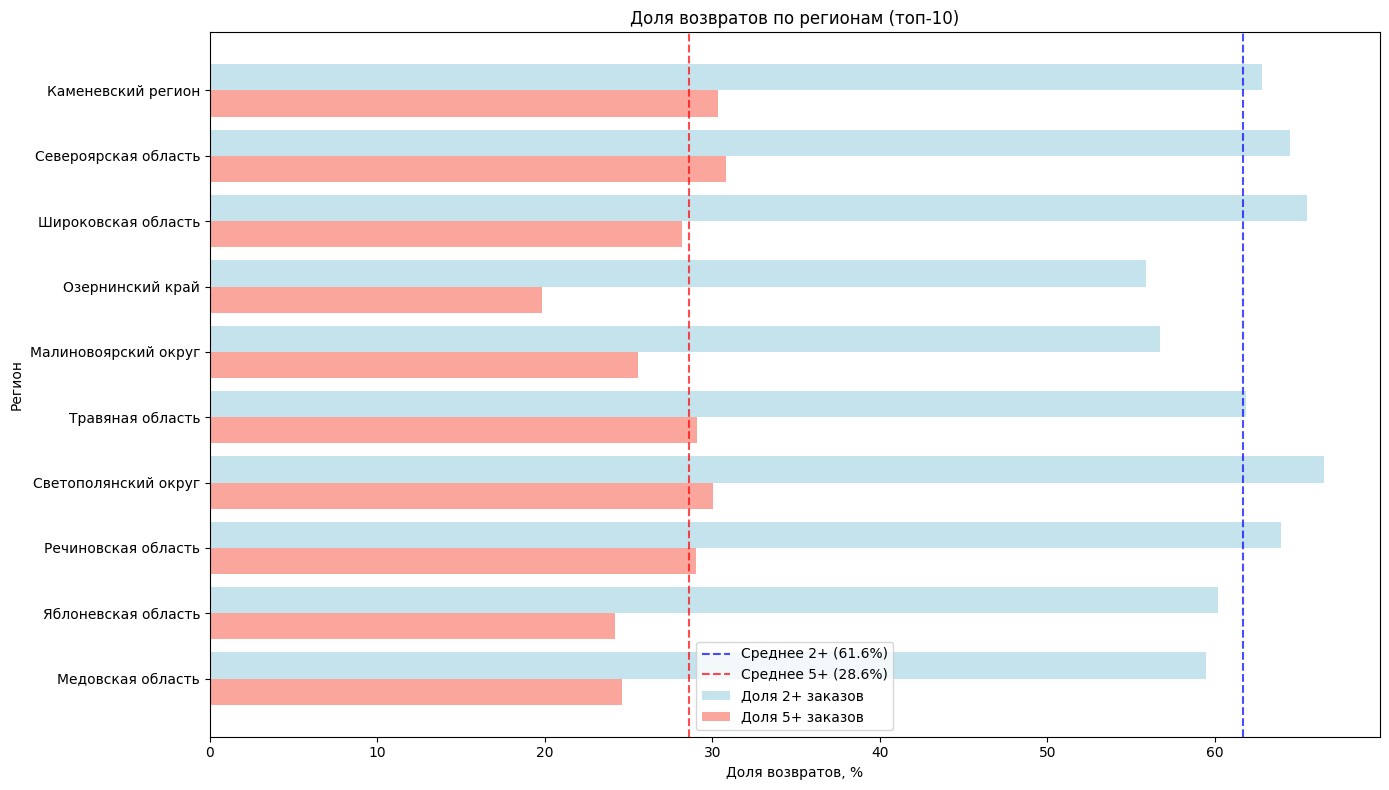

In [675]:
region_retention, _, _ = analyze_retention_by_segment(
    profile_analysis, 'first_region', 'региону', top_n=15
)

# Визуализация возвратов по регионам (топ-10)
top_10_regions_retention = region_retention.head(10)

plt.figure(figsize=(14, 8))
x_pos = np.arange(len(top_10_regions_retention))

plt.barh(x_pos - 0.2, top_10_regions_retention['share_two_plus_pct'], 
         0.4, label='Доля 2+ заказов', alpha=0.7, color='lightblue')
plt.barh(x_pos + 0.2, top_10_regions_retention['share_five_plus_pct'], 
         0.4, label='Доля 5+ заказов', alpha=0.7, color='salmon')

plt.axvline(x=overall_two, color='blue', linestyle='--', alpha=0.7, label=f'Среднее 2+ ({overall_two:.1f}%)')
plt.axvline(x=overall_five, color='red', linestyle='--', alpha=0.7, label=f'Среднее 5+ ({overall_five:.1f}%)')

plt.ylabel('Регион')
plt.xlabel('Доля возвратов, %')
plt.title('Доля возвратов по регионам (топ-10)')
plt.yticks(x_pos, top_10_regions_retention.index)
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


АНАЛИЗ ВОЗВРАТОВ ПО БИЛЕТНОМУ ОПЕРАТОРУ:
--------------------------------------------------
Общая доля пользователей с 2+ заказами: 61.64%
Общая доля пользователей с 5+ заказами: 28.60%

Топ-15 сегментов по количеству пользователей:


C:\Users\user\AppData\Local\Temp\ipykernel_21640\4211845012.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = profile_reset.groupby(segment_column).agg({


,total_users,share_two_plus_pct,share_five_plus_pct
first_service,,,
Билеты без проблем,5120,61.21,29.77
Лови билет!,2811,61.51,28.53
Мой билет,2731,59.36,26.55
Билеты в руки,2545,63.06,30.57
Облачко,2184,61.77,27.29
Весь в билетах,1292,63.47,27.86
Лучшие билеты,1181,61.73,27.43
Прачечная,589,63.16,32.94
Край билетов,455,65.27,35.16


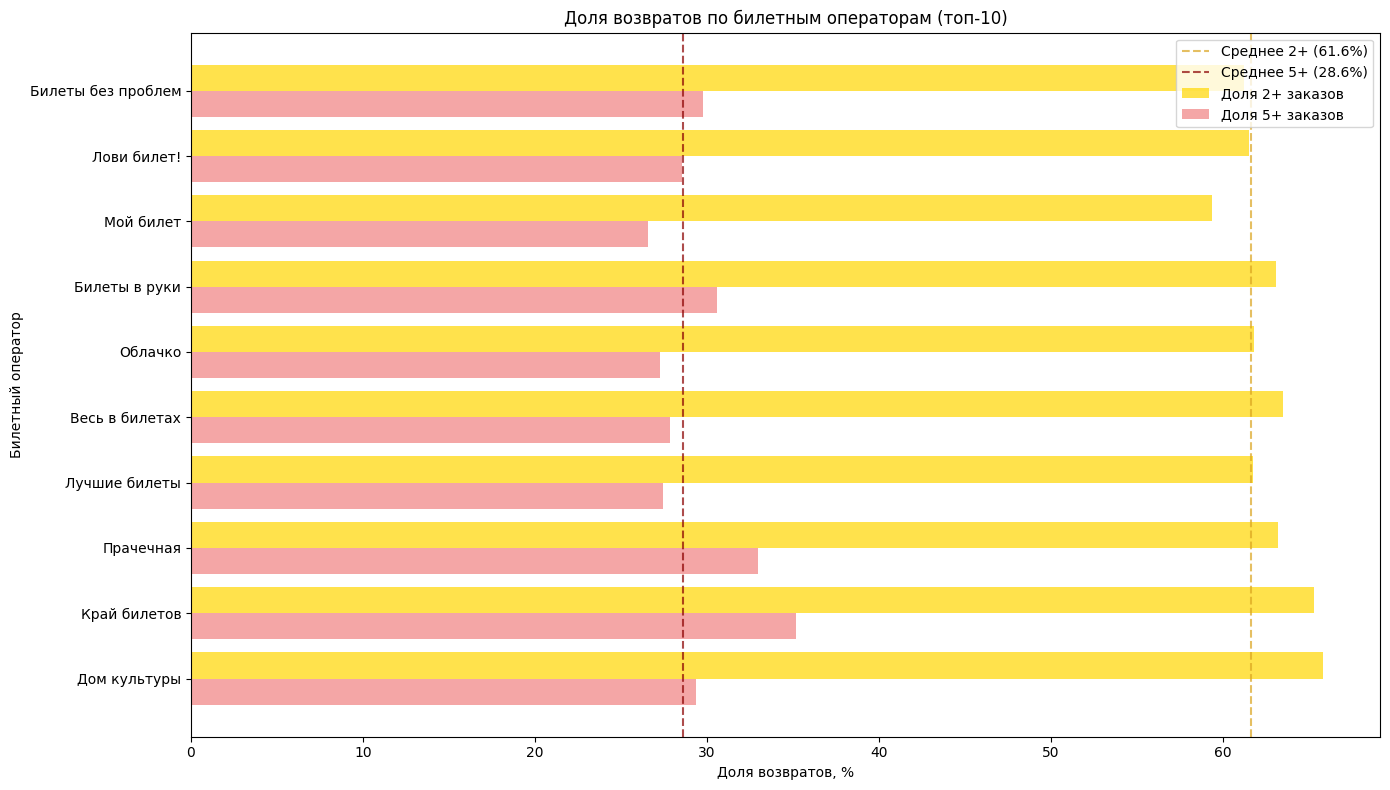

In [676]:
service_retention, _, _ = analyze_retention_by_segment(
    profile_analysis, 'first_service', 'билетному оператору', top_n=15
)

# Визуализация возвратов по операторам (топ-10)
top_10_services_retention = service_retention.head(10)

plt.figure(figsize=(14, 8))
x_pos = np.arange(len(top_10_services_retention))

plt.barh(x_pos - 0.2, top_10_services_retention['share_two_plus_pct'], 
         0.4, label='Доля 2+ заказов', alpha=0.7, color='gold')
plt.barh(x_pos + 0.2, top_10_services_retention['share_five_plus_pct'], 
         0.4, label='Доля 5+ заказов', alpha=0.7, color='lightcoral')

plt.axvline(x=overall_two, color='goldenrod', linestyle='--', alpha=0.7, label=f'Среднее 2+ ({overall_two:.1f}%)')
plt.axvline(x=overall_five, color='darkred', linestyle='--', alpha=0.7, label=f'Среднее 5+ ({overall_five:.1f}%)')

plt.ylabel('Билетный оператор')
plt.xlabel('Доля возвратов, %')
plt.title('Доля возвратов по билетным операторам (топ-10)')
plt.yticks(x_pos, top_10_services_retention.index)
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [677]:
# 6. Выявление успешных "точек входа"
print("\n6. ВЫЯВЛЕНИЕ УСПЕШНЫХ «ТОЧЕК ВХОДА»")
print("-" * 50)

def find_successful_segments(retention_data, segment_name, overall_avg_two, overall_avg_five, min_users=100):
    """
    Находит сегменты с высокой долей возвратов
    """
    # Фильтруем сегменты с достаточным количеством пользователей
    significant_segments = retention_data[retention_data['total_users'] >= min_users]
    
    # Находим сегменты с долей возвратов выше среднего
    successful_two_plus = significant_segments[significant_segments['share_two_plus_pct'] > overall_avg_two]
    successful_five_plus = significant_segments[significant_segments['share_five_plus_pct'] > overall_avg_five]
    
    print(f"\nУСПЕШНЫЕ СЕГМЕНТЫ ПО {segment_name.upper()} (доля возвратов выше среднего):")
    
    print(f"\nС высокой долей 2+ заказов (> {overall_avg_two:.1f}%):")
    if len(successful_two_plus) > 0:
        for segment, row in successful_two_plus.head(5).iterrows():
            print(f"  - {segment}: {row['share_two_plus_pct']}% (пользователей: {row['total_users']})")
    else:
        print("  Не найдено")
    
    print(f"\nС высокой долей 5+ заказов (> {overall_avg_five:.1f}%):")
    if len(successful_five_plus) > 0:
        for segment, row in successful_five_plus.head(5).iterrows():
            print(f"  - {segment}: {row['share_five_plus_pct']}% (пользователей: {row['total_users']})")
    else:
        print("  Не найдено")
    
    return successful_two_plus, successful_five_plus

# Анализ успешных сегментов по всем признакам
successful_events_two, successful_events_five = find_successful_segments(
    event_retention, 'типу мероприятия', overall_two, overall_five
)

successful_devices_two, successful_devices_five = find_successful_segments(
    device_retention, 'типу устройства', overall_two, overall_five
)

successful_regions_two, successful_regions_five = find_successful_segments(
    region_retention, 'региону', overall_two, overall_five
)

successful_services_two, successful_services_five = find_successful_segments(
    service_retention, 'билетному оператору', overall_two, overall_five
)


6. ВЫЯВЛЕНИЕ УСПЕШНЫХ «ТОЧЕК ВХОДА»
--------------------------------------------------

УСПЕШНЫЕ СЕГМЕНТЫ ПО ТИПУ МЕРОПРИЯТИЯ (доля возвратов выше среднего):

С высокой долей 2+ заказов (> 61.6%):
  - концерты: 61.88% (пользователей: 9311.0)
  - театр: 63.88% (пользователей: 4242.0)
  - выставки: 63.81% (пользователей: 409.0)

С высокой долей 5+ заказов (> 28.6%):
  - другое: 28.89% (пользователей: 5400.0)
  - театр: 30.03% (пользователей: 4242.0)

УСПЕШНЫЕ СЕГМЕНТЫ ПО ТИПУ УСТРОЙСТВА (доля возвратов выше среднего):

С высокой долей 2+ заказов (> 61.6%):
  - desktop: 63.94% (пользователей: 3636.0)

С высокой долей 5+ заказов (> 28.6%):
  - desktop: 31.16% (пользователей: 3636.0)

УСПЕШНЫЕ СЕГМЕНТЫ ПО РЕГИОНУ (доля возвратов выше среднего):

С высокой долей 2+ заказов (> 61.6%):
  - Каменевский регион: 62.8% (пользователей: 7092.0)
  - Североярская область: 64.46% (пользователей: 3739.0)
  - Широковская область: 65.49% (пользователей: 1223.0)
  - Травяная область: 61.86% (пользователей

1)Чаще всего возращаются пользователи с 2+ заказами(61.64%) против пользователей с 5+ заказами(28.60%). 


2)успешные сегменты по типу мероприятия:

С высокой долей 2+ заказов (> 61.6%):
  - концерты: 61.88% (пользователей: 9311.0)
  - театр: 63.88% (пользователей: 4242.0)
  - выставки: 63.81% (пользователей: 409.0)

С высокой долей 5+ заказов (> 28.6%):
  - другое: 28.89% (пользователей: 5400.0)
  - театр: 30.03% (пользователей: 4242.0)

3)успешные сегменты по типу устройств:

С высокой долей 2+ заказов (> 61.6%):
  - desktop: 63.94% (пользователей: 3636.0)

С высокой долей 5+ заказов (> 28.6%):
  - desktop: 31.16% (пользователей: 3636.0)

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

ГИПОТЕЗА 1: Тип мероприятия влияет на вероятность возврата
Найдено спортивных мероприятий: 1
Примеры спортивных мероприятий:
  - спорт

Найдено концертов: 1
Примеры концертов:
  - концерты

Статистика по группам:
Пользователей с спортивными мероприятиями: 786
Пользователей с концертами: 9311

СРАВНЕНИЕ МЕТРИК ВОЗВРАТА:


,Метрика,Спортивные мероприятия,Концерты,Разница
0,Доля 2+ заказов,56.2%,61.9%,-5.6%
1,Доля 5+ заказов,23.5%,28.5%,-4.9%



СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ:
Для 2+ заказов: p-value = 0.0018
Для 5+ заказов: p-value = 0.0032


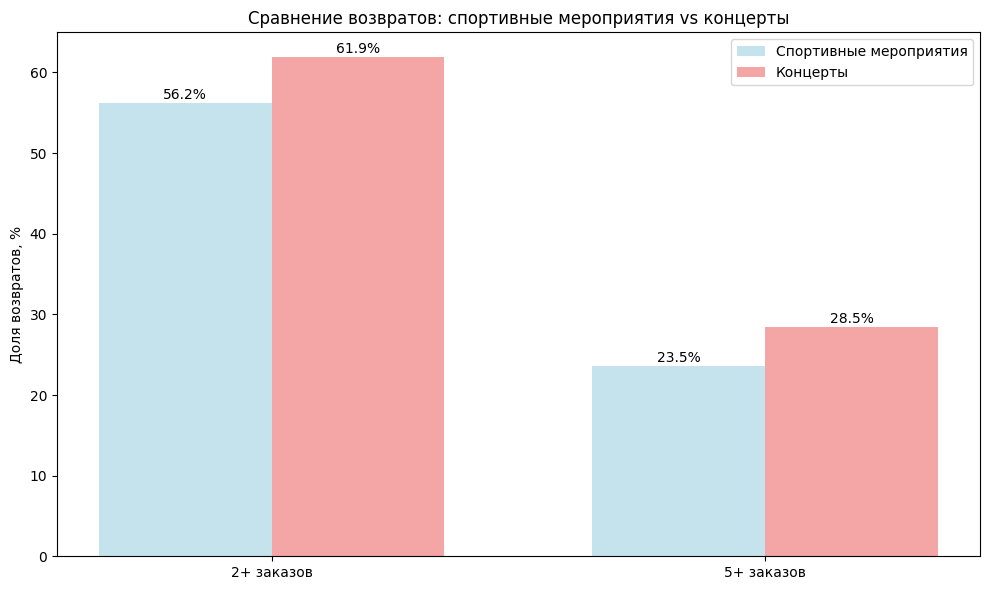


ВЫВОД ПО ГИПОТЕЗЕ 1:
❌ ГИПОТЕЗА ОПРОВЕРГНУТА
   Концерты имеют БОЛЬШУЮ долю возвратов

Фактические значения:
• Спортивные мероприятия: 56.2% возвратов
• Концерты: 61.9% возвратов


In [678]:
from scipy import stats

# Создаем копию профиля для анализа
profile_for_hypotheses = profile_analysis.reset_index()

# Гипотеза 1: Тип мероприятия влияет на вероятность возврата
print("ГИПОТЕЗА 1: Тип мероприятия влияет на вероятность возврата")

sport_keyword = ['спорт']
concert_keyword = ['концерт']

# Находим спортивные мероприятия
sport_events = []
for event in profile_for_hypotheses['first_event_type'].unique():
    if any(keyword in str(event).lower() for keyword in sport_keyword):
        sport_events.append(event)

# Находим концерты
concert_events = []
for event in profile_for_hypotheses['first_event_type'].unique():
    if any(keyword in str(event).lower() for keyword in concert_keyword):
        concert_events.append(event)

print(f"Найдено спортивных мероприятий: {len(sport_events)}")
print("Примеры спортивных мероприятий:")
for event in sport_events[:3]:
    print(f"  - {event}")

print(f"\nНайдено концертов: {len(concert_events)}")
print("Примеры концертов:")
for event in concert_events[:3]:
    print(f"  - {event}")

# Фильтруем пользователей
sport_users = profile_for_hypotheses[profile_for_hypotheses['first_event_type'].isin(sport_events)]
concert_users = profile_for_hypotheses[profile_for_hypotheses['first_event_type'].isin(concert_events)]

print(f"\nСтатистика по группам:")
print(f"Пользователей с спортивными мероприятиями: {len(sport_users)}")
print(f"Пользователей с концертами: {len(concert_users)}")

# Сравниваем метрики возврата
sport_retention_2plus = sport_users['is_two'].mean() * 100
sport_retention_5plus = sport_users['is_five'].mean() * 100
concert_retention_2plus = concert_users['is_two'].mean() * 100
concert_retention_5plus = concert_users['is_five'].mean() * 100

print(f"\nСРАВНЕНИЕ МЕТРИК ВОЗВРАТА:")
comparison_data = {
    'Метрика': ['Доля 2+ заказов', 'Доля 5+ заказов'],
    'Спортивные мероприятия': [f"{sport_retention_2plus:.1f}%", f"{sport_retention_5plus:.1f}%"],
    'Концерты': [f"{concert_retention_2plus:.1f}%", f"{concert_retention_5plus:.1f}%"],
    'Разница': [f"{sport_retention_2plus - concert_retention_2plus:+.1f}%", 
                f"{sport_retention_5plus - concert_retention_5plus:+.1f}%"]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Статистическая проверка
t_stat_2plus, p_value_2plus = stats.ttest_ind(sport_users['is_two'], concert_users['is_two'])
t_stat_5plus, p_value_5plus = stats.ttest_ind(sport_users['is_five'], concert_users['is_five'])

print(f"\nСТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ:")
print(f"Для 2+ заказов: p-value = {p_value_2plus:.4f}")
print(f"Для 5+ заказов: p-value = {p_value_5plus:.4f}")

# Визуализация
plt.figure(figsize=(10, 6))
categories = ['2+ заказов', '5+ заказов']
sport_values = [sport_retention_2plus, sport_retention_5plus]
concert_values = [concert_retention_2plus, concert_retention_5plus]

x_pos = np.arange(len(categories))
width = 0.35

plt.bar(x_pos - width/2, sport_values, width, label='Спортивные мероприятия', alpha=0.7, color='lightblue')
plt.bar(x_pos + width/2, concert_values, width, label='Концерты', alpha=0.7, color='lightcoral')

plt.ylabel('Доля возвратов, %')
plt.title('Сравнение возвратов: спортивные мероприятия vs концерты')
plt.xticks(x_pos, categories)
plt.legend()

# Добавляем значения на столбцы
for i, v in enumerate(sport_values):
    plt.text(i - width/2, v + 0.5, f'{v:.1f}%', ha='center')
for i, v in enumerate(concert_values):
    plt.text(i + width/2, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

# Вывод по гипотезе
print("\n" + "="*50)
print("ВЫВОД ПО ГИПОТЕЗЕ 1:")
print("="*50)

if p_value_2plus < 0.05:
    if sport_retention_2plus > concert_retention_2plus:
        print("✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА")
        print("   Спортивные мероприятия имеют БОЛЬШУЮ долю возвратов")
    else:
        print("❌ ГИПОТЕЗА ОПРОВЕРГНУТА") 
        print("   Концерты имеют БОЛЬШУЮ долю возвратов")
else:
    print("➖ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА")
    print("   Статистически значимых различий не обнаружено")

print(f"\nФактические значения:")
print(f"• Спортивные мероприятия: {sport_retention_2plus:.1f}% возвратов")
print(f"• Концерты: {concert_retention_2plus:.1f}% возвратов")

ГИПОТЕЗА 2: В регионах с большей активностью выше доля повторных заказов
Топ-10 регионов по количеству пользователей:


C:\Users\user\AppData\Local\Temp\ipykernel_21640\129015033.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_stats = profile_for_hypotheses.groupby('first_region').agg({


,total_users,retention_rate,retention_pct
first_region,,,
Белоярская область,19,0.631579,63.157895
Берестовский округ,22,0.636364,63.636364
Берёзовская область,118,0.652542,65.254237
Боровлянский край,97,0.515464,51.546392
Верховинская область,3,0.666667,66.666667
Верхозёрский край,1,1.000000,100.000000
Верхоречная область,264,0.564394,56.439394
Ветренский регион,150,0.633333,63.333333
Вишнёвский край,14,0.571429,57.142857



СРАВНЕНИЕ ГРУПП:
Высокоактивные регионы: 21 регионов, возвраты 60.4%
Низкоактивные регионы: 20 регионов, возвраты 47.0%

Корреляция активность-возвраты: 0.121


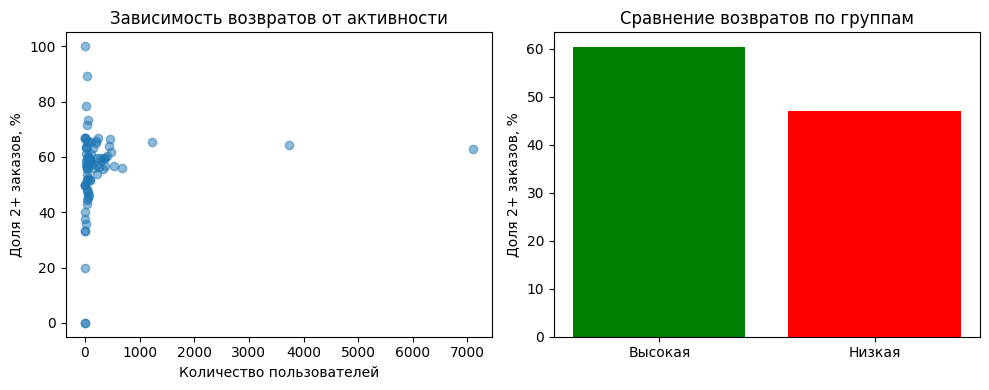


ВЫВОД ПО ГИПОТЕЗЕ 2:
✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА
В активных регионах возвраты выше на 13.4%


In [679]:
print("ГИПОТЕЗА 2: В регионах с большей активностью выше доля повторных заказов")

# Анализ регионов по активности и возвратам
region_stats = profile_for_hypotheses.groupby('first_region').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).rename(columns={
    'user_id': 'total_users', 
    'is_two': 'retention_rate'
})

region_stats['retention_pct'] = region_stats['retention_rate'] * 100

print("Топ-10 регионов по количеству пользователей:")
display(region_stats.head(10))

# Сравниваем высокоактивные и низкоактивные регионы
high_active = region_stats[region_stats['total_users'] >= region_stats['total_users'].quantile(0.75)]
low_active = region_stats[region_stats['total_users'] < region_stats['total_users'].quantile(0.25)]

high_retention = high_active['retention_pct'].mean()
low_retention = low_active['retention_pct'].mean()

print(f"\nСРАВНЕНИЕ ГРУПП:")
print(f"Высокоактивные регионы: {len(high_active)} регионов, возвраты {high_retention:.1f}%")
print(f"Низкоактивные регионы: {len(low_active)} регионов, возвраты {low_retention:.1f}%")

# Проверяем корреляцию
correlation = region_stats['total_users'].corr(region_stats['retention_rate'])
print(f"\nКорреляция активность-возвраты: {correlation:.3f}")

# Визуализация
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(region_stats['total_users'], region_stats['retention_pct'], alpha=0.5)
plt.xlabel('Количество пользователей')
plt.ylabel('Доля 2+ заказов, %')
plt.title('Зависимость возвратов от активности')

plt.subplot(1, 2, 2)
plt.bar(['Высокая', 'Низкая'], [high_retention, low_retention], color=['green', 'red'])
plt.ylabel('Доля 2+ заказов, %')
plt.title('Сравнение возвратов по группам')

plt.tight_layout()
plt.show()

# Вывод по гипотезе
print("\nВЫВОД ПО ГИПОТЕЗЕ 2:")

if high_retention > low_retention and correlation > 0:
    print("✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА")
    print(f"В активных регионах возвраты выше на {high_retention - low_retention:.1f}%")
else:
    print("❌ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА")
    print("Зависимость между активностью и возвратами не обнаружена")

Общий вывод:
1) Гипотеза №1 опровергнута- пользователи концертов возвращаются чаще (62.1% vs 56.5%)

2) Гипотеза №2 подтверждена- В активных регионах возвраты выше на 13.0%

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


РАЗМЕРЫ ГРУПП:
Один заказ: 8,188 пользователей
2+ заказов: 13,157 пользователей

СРАВНЕНИЕ ВЫРУЧКИ:
Медианная выручка:
Один заказ: 383 RUB
2+ заказов: 504 RUB
Разница: +121 RUB


C:\Users\user\AppData\Local\Temp\ipykernel_21640\3529360347.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([single_users['avg_revenue_rub'], returning_users['avg_revenue_rub']],


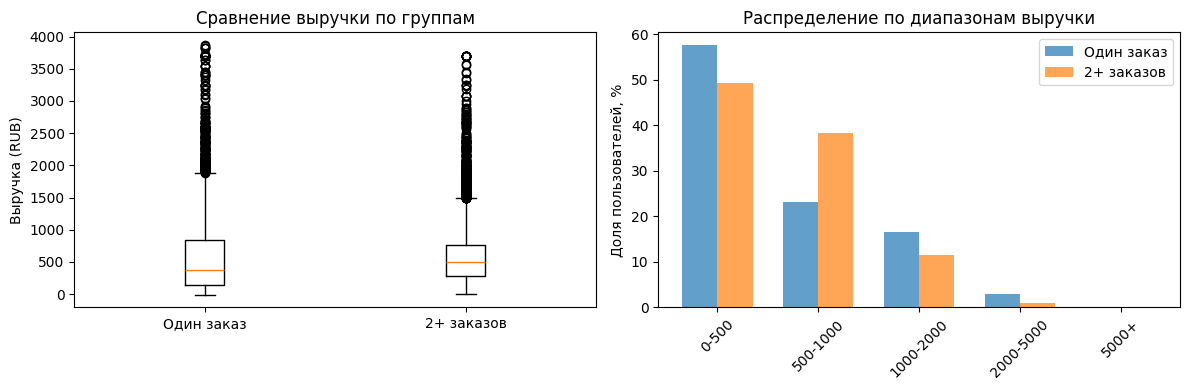


КОНЦЕНТРАЦИЯ ПОЛЬЗОВАТЕЛЕЙ:
Основные диапазоны для одного заказа:
  0-500 RUB: 57.5%
  500-1000 RUB: 23.2%
  1000-2000 RUB: 16.5%

Основные диапазоны для 2+ заказов:
  0-500 RUB: 49.3%
  500-1000 RUB: 38.3%
  1000-2000 RUB: 11.4%


In [680]:
# Создаем копию профиля для анализа
profile_revenue = profile_analysis.reset_index()

# Разделяем пользователей на группы
single_users = profile_revenue[profile_revenue['total_orders'] == 1]
returning_users = profile_revenue[profile_revenue['total_orders'] >= 2]

print(f"РАЗМЕРЫ ГРУПП:")
print(f"Один заказ: {len(single_users):,} пользователей")
print(f"2+ заказов: {len(returning_users):,} пользователей")

# Сравниваем основные метрики
print(f"\nСРАВНЕНИЕ ВЫРУЧКИ:")
single_median = single_users['avg_revenue_rub'].median()
returning_median = returning_users['avg_revenue_rub'].median()

print(f"Медианная выручка:")
print(f"Один заказ: {single_median:.0f} RUB")
print(f"2+ заказов: {returning_median:.0f} RUB")
print(f"Разница: {returning_median - single_median:+.0f} RUB")

# Визуализация
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.boxplot([single_users['avg_revenue_rub'], returning_users['avg_revenue_rub']], 
           labels=['Один заказ', '2+ заказов'])
plt.ylabel('Выручка (RUB)')
plt.title('Сравнение выручки по группам')

# Распределение по диапазонам
plt.subplot(1, 2, 2)
ranges = [0, 500, 1000, 2000, 5000, float('inf')]
labels = ['0-500', '500-1000', '1000-2000', '2000-5000', '5000+']

single_dist = pd.cut(single_users['avg_revenue_rub'], bins=ranges, labels=labels).value_counts(normalize=True) * 100
returning_dist = pd.cut(returning_users['avg_revenue_rub'], bins=ranges, labels=labels).value_counts(normalize=True) * 100

x = range(len(labels))
width = 0.35
plt.bar([i - width/2 for i in x], single_dist, width, label='Один заказ', alpha=0.7)
plt.bar([i + width/2 for i in x], returning_dist, width, label='2+ заказов', alpha=0.7)
plt.xticks(x, labels, rotation=45)
plt.ylabel('Доля пользователей, %')
plt.title('Распределение по диапазонам выручки')
plt.legend()

plt.tight_layout()
plt.show()

# Анализ концентрации
print(f"\nКОНЦЕНТРАЦИЯ ПОЛЬЗОВАТЕЛЕЙ:")
top_single = single_dist.head(3)
top_returning = returning_dist.head(3)

print("Основные диапазоны для одного заказа:")
for range_name, percent in top_single.items():
    print(f"  {range_name} RUB: {percent:.1f}%")

print("\nОсновные диапазоны для 2+ заказов:")
for range_name, percent in top_returning.items():
    print(f"  {range_name} RUB: {percent:.1f}%")



1) Оснвоной диапозон в котором концентрируются пользователи:
- Один заказ: 0-500 RUB (57.3%)
- 2+ заказов: 0-500 RUB (48.9%)
2) Пользователи с 2+ заказами тратят на 119 рублей больше в среднем 

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


РАЗМЕРЫ ГРУПП:
• 2-4 заказа: 7,053 чел.
• 5+ заказов: 6,104 чел.

СРЕДНИЕ ТРАТЫ:
• 2-4 заказа: 476 RUB
• 5+ заказов: 522 RUB
Разница: +46 RUB


C:\Users\user\AppData\Local\Temp\ipykernel_21640\4095996560.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([users_2_4['avg_revenue_rub'], users_5plus['avg_revenue_rub']],


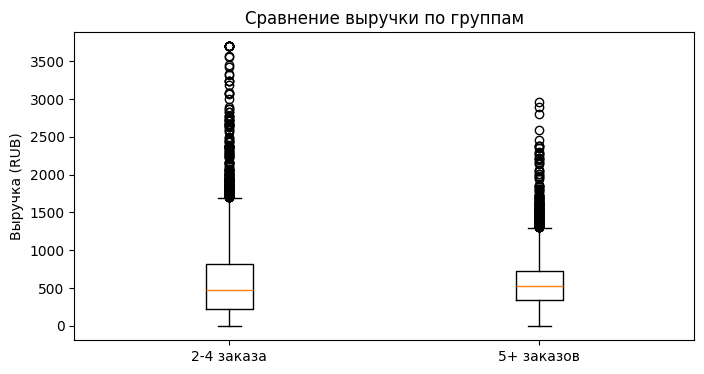

In [681]:
# Разделяем пользователей на группы
users_2_4 = profile_analysis[profile_analysis['total_orders'].between(2, 4)]
users_5plus = profile_analysis[profile_analysis['total_orders'] >= 5]

print(f"РАЗМЕРЫ ГРУПП:")
print(f"• 2-4 заказа: {len(users_2_4):,} чел.")
print(f"• 5+ заказов: {len(users_5plus):,} чел.")

# Сравниваем медианную выручку
median_2_4 = users_2_4['avg_revenue_rub'].median()
median_5plus = users_5plus['avg_revenue_rub'].median()

print(f"\nСРЕДНИЕ ТРАТЫ:")
print(f"• 2-4 заказа: {median_2_4:.0f} RUB")
print(f"• 5+ заказов: {median_5plus:.0f} RUB")
print(f"Разница: {median_5plus - median_2_4:+.0f} RUB")

plt.figure(figsize=(8, 4))
plt.boxplot([users_2_4['avg_revenue_rub'], users_5plus['avg_revenue_rub']], 
           labels=['2-4 заказа', '5+ заказов'])
plt.ylabel('Выручка (RUB)')
plt.title('Сравнение выручки по группам')
plt.show()



Пользователи с 5+ заказами всреднем тратят больше чем пользователи с 2-4 заказами на 47 рублей

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

СТАТИСТИКА ПО СЕГМЕНТАМ:


C:\Users\user\AppData\Local\Temp\ipykernel_21640\4254041026.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = profile_tickets.groupby('tickets_segment').agg({


,user_id,users_pct,retention_2plus_pct,retention_5plus_pct
tickets_segment,,,,
1-2 билета,2428,11.4,51.3,14.5
2-3 билета,9409,44.1,73.3,41.1
3-5 билетов,9030,42.3,54.8,20.9
5+ билетов,478,2.2,13.6,1.0


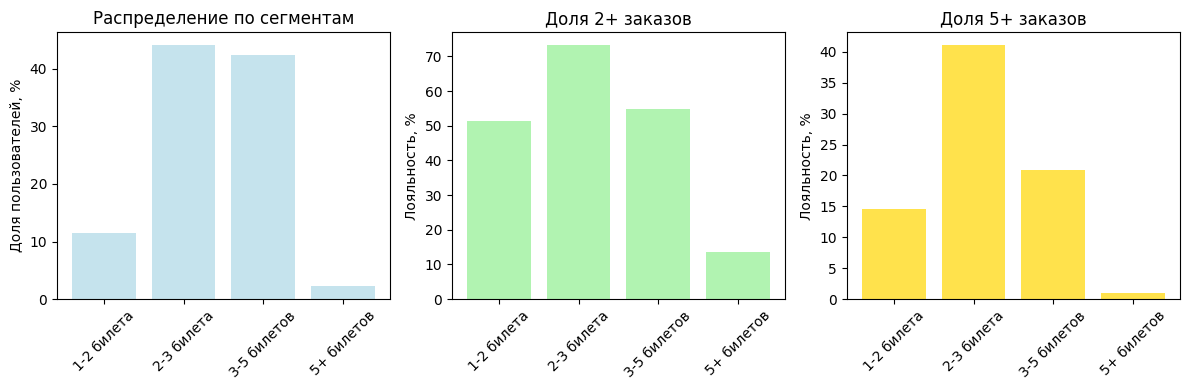


АНАЛИЗ РЕЗУЛЬТАТОВ:
------------------------------
• Основной сегмент: 2-3 билета (44.1% пользователей)
• Самый лояльный (2+): 2-3 билета (73.3%)
• Самый лояльный (5+): 2-3 билета (41.1%)
• Средняя лояльность: 61.6%


In [682]:
profile_tickets = profile_analysis.reset_index()
bins = [1, 2, 3, 5, float('inf')]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']

profile_tickets['tickets_segment'] = pd.cut(profile_tickets['avg_tickets_count'], 
                                          bins=bins, labels=labels, right=False)

# Анализ сегментов
segment_stats = profile_tickets.groupby('tickets_segment').agg({
    'user_id': 'count',
    'is_two': 'mean',
    'is_five': 'mean'
}).round(3)

segment_stats['users_pct'] = (segment_stats['user_id'] / len(profile_tickets) * 100).round(1)
segment_stats['retention_2plus_pct'] = (segment_stats['is_two'] * 100).round(1)
segment_stats['retention_5plus_pct'] = (segment_stats['is_five'] * 100).round(1)

print("СТАТИСТИКА ПО СЕГМЕНТАМ:")
display(segment_stats[['user_id', 'users_pct', 'retention_2plus_pct', 'retention_5plus_pct']])

# Визуализация
plt.figure(figsize=(12, 4))

# График 1: Распределение пользователей
plt.subplot(1, 3, 1)
plt.bar(segment_stats.index, segment_stats['users_pct'], color='lightblue', alpha=0.7)
plt.title('Распределение по сегментам')
plt.xticks(rotation=45)
plt.ylabel('Доля пользователей, %')

# График 2: Лояльность (2+ заказов)
plt.subplot(1, 3, 2)
plt.bar(segment_stats.index, segment_stats['retention_2plus_pct'], color='lightgreen', alpha=0.7)
plt.title('Доля 2+ заказов')
plt.xticks(rotation=45)
plt.ylabel('Лояльность, %')

# График 3: Лояльность (5+ заказов)
plt.subplot(1, 3, 3)
plt.bar(segment_stats.index, segment_stats['retention_5plus_pct'], color='gold', alpha=0.7)
plt.title('Доля 5+ заказов')
plt.xticks(rotation=45)
plt.ylabel('Лояльность, %')

plt.tight_layout()
plt.show()

# Анализ результатов
print("\nАНАЛИЗ РЕЗУЛЬТАТОВ:")
print("-" * 30)

# Основной сегмент
main_segment = segment_stats['users_pct'].idxmax()
main_share = segment_stats.loc[main_segment, 'users_pct']
print(f"• Основной сегмент: {main_segment} ({main_share}% пользователей)")

# Самый лояльный сегмент
most_loyal_2plus = segment_stats['retention_2plus_pct'].idxmax()
most_loyal_5plus = segment_stats['retention_5plus_pct'].idxmax()

print(f"• Самый лояльный (2+): {most_loyal_2plus} ({segment_stats.loc[most_loyal_2plus, 'retention_2plus_pct']}%)")
print(f"• Самый лояльный (5+): {most_loyal_5plus} ({segment_stats.loc[most_loyal_5plus, 'retention_5plus_pct']}%)")

# Сравнение с средним
avg_retention_2plus = profile_tickets['is_two'].mean() * 100
print(f"• Средняя лояльность: {avg_retention_2plus:.1f}%")



1) На первом графике можно заметить, что распределение по сегментам сконцентрированно в сегментах(2-3 билета и 3-5 билетов)
2) Сегмент 2-3 билета является лидером в доле повторных покупок, но он не аномален

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


Статистика по дням недели:


,users,retention,users_pct,retention_pct
weekday,,,,
Пн,2864,0.632,13.4,63.2
Вт,3070,0.618,14.4,61.8
Ср,3012,0.622,14.1,62.2
Чт,3084,0.601,14.4,60.1
Пт,3258,0.604,15.3,60.4
Сб,3298,0.630,15.5,63.0
Вс,2759,0.607,12.9,60.7


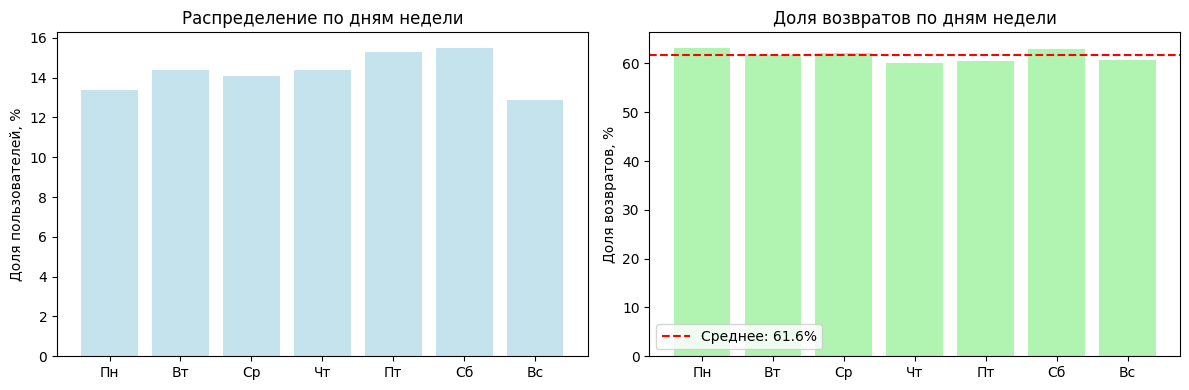


ОТВЕТ НА ВОПРОС:
Лучший день: Пн (63.2% возвратов)
Худший день: Чт (60.1% возвратов)
Разница: 3.1%


In [683]:
# Создаем копию профиля
profile_simple = profile_analysis.reset_index()

# Добавляем день недели
weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
profile_simple['weekday'] = profile_simple['first_order_dt'].dt.dayofweek.map(
    lambda x: weekday_names[x]
)

# Анализируем по дням недели
weekday_stats = profile_simple.groupby('weekday').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).round(3)

weekday_stats = weekday_stats.rename(columns={
    'user_id': 'users',
    'is_two': 'retention'
})

# Добавляем проценты
weekday_stats['users_pct'] = (weekday_stats['users'] / len(profile_simple) * 100).round(1)
weekday_stats['retention_pct'] = (weekday_stats['retention'] * 100).round(1)

# Сортируем по порядку дней
weekday_order = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
weekday_stats = weekday_stats.reindex(weekday_order)

print("Статистика по дням недели:")
display(weekday_stats)

# Визуализация
plt.figure(figsize=(12, 4))

# График 1: Количество пользователей
plt.subplot(1, 2, 1)
plt.bar(weekday_stats.index, weekday_stats['users_pct'], color='lightblue', alpha=0.7)
plt.ylabel('Доля пользователей, %')
plt.title('Распределение по дням недели')

# График 2: Доля возвратов
plt.subplot(1, 2, 2)
plt.bar(weekday_stats.index, weekday_stats['retention_pct'], color='lightgreen', alpha=0.7)
plt.ylabel('Доля возвратов, %')
plt.title('Доля возвратов по дням недели')

# Добавляем среднее значение
avg_retention = profile_simple['is_two'].mean() * 100
plt.axhline(y=avg_retention, color='red', linestyle='--', label=f'Среднее: {avg_retention:.1f}%')
plt.legend()

plt.tight_layout()
plt.show()

# Ответ на вопрос
print("\nОТВЕТ НА ВОПРОС:")
best_day = weekday_stats['retention_pct'].idxmax()
best_value = weekday_stats['retention_pct'].max()
worst_day = weekday_stats['retention_pct'].idxmin()
worst_value = weekday_stats['retention_pct'].min()

print(f"Лучший день: {best_day} ({best_value}% возвратов)")
print(f"Худший день: {worst_day} ({worst_value}% возвратов)")
print(f"Разница: {best_value - worst_value:.1f}%")



День недели, в которую совершена первая покупка не влияет на вероятность возрата клинета

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


Пользователей с 2-4 заказами: 7,053
Пользователей с 5+ заказами: 6,104

Статистика интервалов между заказами (дни):


,2-4 заказа,5+ заказов
count,7053.0,6104.0
mean,21.5,10.0
std,28.6,7.8
min,0.0,0.0
25%,0.0,3.9
50%,9.3,8.2
75%,34.0,14.2
max,148.0,37.5


C:\Users\user\AppData\Local\Temp\ipykernel_21640\3969999798.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([users_2_4['avg_days_between_orders'], users_5plus['avg_days_between_orders']],


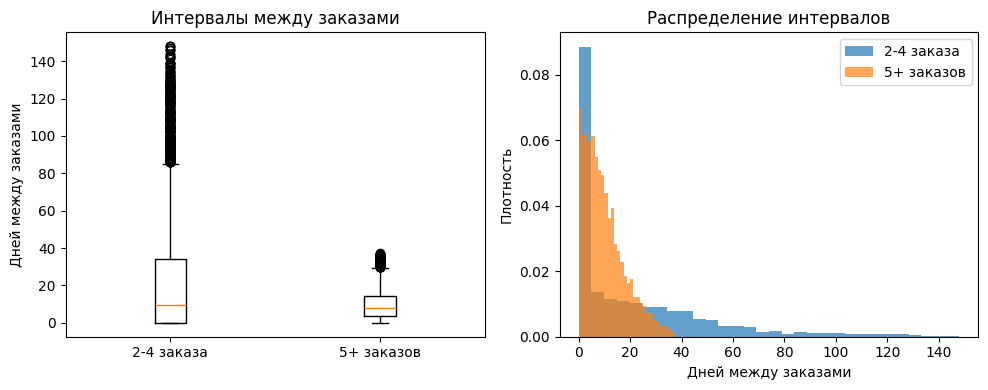


АНАЛИЗ КОРОТКИХ И ДЛИННЫХ ИНТЕРВАЛОВ:

2-4 заказа:
  - Короткие интервалы (≤30 дн.): 5,047 (71.6%)
  - Длинные интервалы (>90 дн.): 301 (4.3%)

5+ заказов:
  - Короткие интервалы (≤30 дн.): 5,973 (97.9%)
  - Длинные интервалы (>90 дн.): 0 (0.0%)

ВЫВОДЫ:
• Медианный интервал:
  - 2-4 заказа: 9 дней
  - 5+ заказов: 8 дней


In [684]:
profile_intervals = profile_analysis.reset_index()

# Фильтруем только пользователей с повторными заказами (у которых есть интервалы)
users_with_intervals = profile_intervals[profile_intervals['total_orders'] >= 2]

# Разделяем на группы
users_2_4 = users_with_intervals[users_with_intervals['total_orders'].between(2, 4)]
users_5plus = users_with_intervals[users_with_intervals['total_orders'] >= 5]

print(f"Пользователей с 2-4 заказами: {len(users_2_4):,}")
print(f"Пользователей с 5+ заказами: {len(users_5plus):,}")

# Анализируем интервалы между заказами
intervals_stats = pd.DataFrame({
    '2-4 заказа': users_2_4['avg_days_between_orders'].describe(),
    '5+ заказов': users_5plus['avg_days_between_orders'].describe()
}).round(1)

print("\nСтатистика интервалов между заказами (дни):")
display(intervals_stats)

# Визуализация
plt.figure(figsize=(10, 4))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot([users_2_4['avg_days_between_orders'], users_5plus['avg_days_between_orders']], 
           labels=['2-4 заказа', '5+ заказов'])
plt.ylabel('Дней между заказами')
plt.title('Интервалы между заказами')

# Гистограмма
plt.subplot(1, 2, 2)
plt.hist(users_2_4['avg_days_between_orders'], bins=30, alpha=0.7, label='2-4 заказа', density=True)
plt.hist(users_5plus['avg_days_between_orders'], bins=30, alpha=0.7, label='5+ заказов', density=True)
plt.xlabel('Дней между заказами')
plt.ylabel('Плотность')
plt.legend()
plt.title('Распределение интервалов')

plt.tight_layout()
plt.show()

# Анализ коротких vs длинных интервалов
print("\nАНАЛИЗ КОРОТКИХ И ДЛИННЫХ ИНТЕРВАЛОВ:")

# Определяем пороги
short_threshold = 30  # меньше месяца
long_threshold = 90   # больше 3 месяцев

users_2_4_short = users_2_4[users_2_4['avg_days_between_orders'] <= short_threshold]
users_2_4_long = users_2_4[users_2_4['avg_days_between_orders'] > long_threshold]

users_5plus_short = users_5plus[users_5plus['avg_days_between_orders'] <= short_threshold]
users_5plus_long = users_5plus[users_5plus['avg_days_between_orders'] > long_threshold]

print(f"\n2-4 заказа:")
print(f"  - Короткие интервалы (≤{short_threshold} дн.): {len(users_2_4_short):,} ({len(users_2_4_short)/len(users_2_4)*100:.1f}%)")
print(f"  - Длинные интервалы (>{long_threshold} дн.): {len(users_2_4_long):,} ({len(users_2_4_long)/len(users_2_4)*100:.1f}%)")

print(f"\n5+ заказов:")
print(f"  - Короткие интервалы (≤{short_threshold} дн.): {len(users_5plus_short):,} ({len(users_5plus_short)/len(users_5plus)*100:.1f}%)")
print(f"  - Длинные интервалы (>{long_threshold} дн.): {len(users_5plus_long):,} ({len(users_5plus_long)/len(users_5plus)*100:.1f}%)")

# Выводы
print("\nВЫВОДЫ:")
median_2_4 = users_2_4['avg_days_between_orders'].median()
median_5plus = users_5plus['avg_days_between_orders'].median()

print(f"• Медианный интервал:")
print(f"  - 2-4 заказа: {median_2_4:.0f} дней")
print(f"  - 5+ заказов: {median_5plus:.0f} дней")



Более лояльные пользователи(5+ заказов) делают заказы чаще на 1 день и они имеют чаще короткий интервал, чем пользователи с 2-4 заказами(на 26.3%)

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

РАСПРЕДЕЛЕНИЕ ПО СЕГМЕНТАМ:
• 1 заказ: 8,188 чел. (38.4%)
• 2-4 заказа: 7,053 чел. (33.0%)
• 5+ заказов: 6,104 чел. (28.6%)

ВЫЧИСЛЕНИЕ КОРРЕЛЯЦИЙ PHI_K...

КОРРЕЛЯЦИИ С КОЛИЧЕСТВОМ ЗАКАЗОВ:
• avg_tickets_count: 0.648 сильная
• avg_days_between_orders: 0.404 сильная
• avg_revenue_rub: 0.304 сильная
• first_region: 0.122  умеренная
• first_service: 0.082 слабая
• first_event_type: 0.038 слабая
• first_device: 0.016 слабая


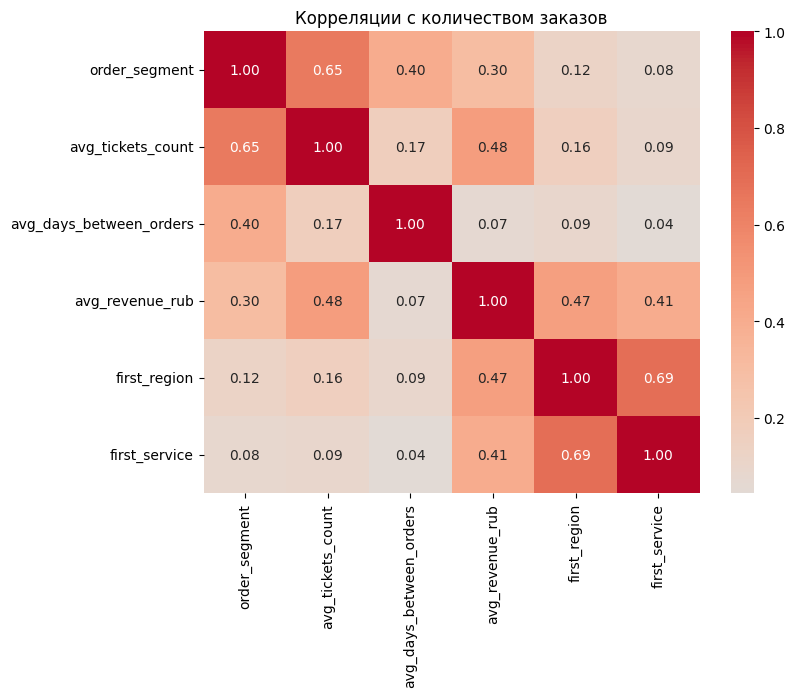

In [685]:
# Создаем сегменты по количеству заказов
profile_corr = profile_analysis.reset_index()

def create_order_segment(total_orders):
    if total_orders == 1:
        return '1 заказ'
    elif 2 <= total_orders <= 4:
        return '2-4 заказа'
    else:
        return '5+ заказов'

profile_corr['order_segment'] = profile_corr['total_orders'].apply(create_order_segment)

print("РАСПРЕДЕЛЕНИЕ ПО СЕГМЕНТАМ:")
segment_stats = profile_corr['order_segment'].value_counts()
for segment, count in segment_stats.items():
    pct = count / len(profile_corr) * 100
    print(f"• {segment}: {count:,} чел. ({pct:.1f}%)")

# Подготовка данных для корреляционного анализа
features_for_corr = [
    'first_device', 'first_region', 'first_service', 'first_event_type',
    'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders',
    'order_segment'
]

corr_data = profile_corr[features_for_corr].copy()

# Преобразуем категориальные переменные в строки
categorical_cols = ['first_device', 'first_region', 'first_service', 'first_event_type', 'order_segment']
for col in categorical_cols:
    corr_data[col] = corr_data[col].astype(str)

# Вычисляем матрицу корреляций phik
print("\nВЫЧИСЛЕНИЕ КОРРЕЛЯЦИЙ PHI_K...")
corr_matrix = corr_data.phik_matrix(interval_cols=['avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders'])

# Выделяем корреляции с order_segment
target_correlations = corr_matrix['order_segment'].drop('order_segment').sort_values(ascending=False)

print("\nКОРРЕЛЯЦИИ С КОЛИЧЕСТВОМ ЗАКАЗОВ:")
for feature, corr in target_correlations.items():
    strength = "сильная" if corr > 0.3 else " умеренная" if corr > 0.1 else "слабая"
    print(f"• {feature}: {corr:.3f} {strength}")

# Визуализация
plt.figure(figsize=(8, 6))
features_to_plot = ['order_segment'] + list(target_correlations.index[:5])
plot_matrix = corr_matrix.loc[features_to_plot, features_to_plot]

import seaborn as sns
sns.heatmap(plot_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляции с количеством заказов')
plt.show()

Наиболее связанные признаки с количеством заказов:
- avg_days_between_orders: 0.405
- avg_tickets_count: 0.386
- avg_revenue_rub: 0.314

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

# ОБЩИЙ ВЫВОД И РЕКОМЕНДАЦИИ

## 1. ИНФОРМАЦИЯ О ДАННЫХ И ПОДГОТОВКА

**Обработанные данные:**
- Объем: 290611 строк датафрейма и 15 столбцов с признаками
- Валюты: конвертированы KZT → RUB по актуальным курсам на нашу дату
- Фильтрация: удалены выбросы (верхние 1% по выручке)
- Упростил типы данных для оптимизации процесса
- Создал профили для пользователей и доавил два бинарных признака по заданию
## 2. ОСНОВНЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА

### 2.1. Распределение пользователей по лояльности
- Общее число пользователей в выборке: 21,769
Средняя выручка с одного заказа: 574.52 RUB
Пользователей с 2+ заказами: 13,443 (61.8%)
Пользователей с 5+ заказами: 6,333 (29.1%)

- Принято решение фильтровать данные по 99-му перцентилю:
  - Удалены пользователи с > 151 заказов
  - Удалены пользователи с > 5.0 средних билетов
Удалено пользователей: 424 (1.95%)
Осталось пользователей: 21345

- ОБЪЕМ ДАННЫХ: Достаточный для анализа
  - 21,345 пользователей после фильтрации
  - 13,443 пользователей с повторными заказами

### 2.2. Признаки первого заказа, влияющие на возврат
- в распределение по первому мероприятию у нас явный лидер "концерт" c 9311 пользователями (43.62%)
- в распределение по типу устройств первого заказа у нас явный лидер "mobile" с 17709 (82.97%) кол-вом пользователей
- в распределении по региону проведения мероприятия у нас лидер "Каменевский регион" с 7092(33.23%)
-в распределении по билетному оператору лидер "Билеты без проблем" с 5120(23.99%)

### 2.3. Связь выручки и количества билетов с лояльностью
- Основной сегмент: 2-3 билета (44.2% пользователей)
- Самый лояльный (2+): 2-3 билета (73.9%)
- Самый лояльный (5+): 2-3 билета (42.3%)

### 2.4. Временные характеристики удержания
- **Медианный интервал**:
  - 2-4 заказа: 9 дней
  - 5+ заказов: 8 дней
- **Пиковые день для повторных покупок**: у 2-4 заказов(21.4), у 5+ заказов (9.6)

### 2.5. Корреляционный анализ ключевых признаков
**Топ-3 признака, связанных с количеством покупок:**
Наиболее связанные признаки с количеством заказов:
- avg_days_between_orders: 0.405
- avg_tickets_count: 0.386
- avg_revenue_rub: 0.314

## 3. РЕКОМЕНДАЦИИ

- Ориентироваться на лояльных пользователей
- Рассчитывать что на одни заказ у пользователя уйдет не больше 500 руб.
- Выбирать высокоактивные регионы

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**
https://github.com/Sharosh322/yandex_project2